# MSci Project - Thompson-1

## Index 

[Initialisation and Testing](#init)
1. [Cooling Single Ion](#single)
    1. [Case I - Decay and off-resonant excitation not considered](#s_case1)
    2. [Case II - Decay considered, off-resonant excitation not considered](#s_case2)
    3. [Case III - Decay and off-resonant excitation considered](#s_case3)
2. [Cooling Two Ions](#two)
3. [Cooling More than two ions](#more)
    1. [3 ions planar crystal](#3ions)
    2. [4 ions planar crystal](#4ions)

[(Maybe) Useful Codes](#code)

## Initialisation and Testing<a id="init"></a>

In [2]:
import numpy as np
import scipy as sp
import timeit
import matplotlib.pyplot as plt
import random
import pickle
from collections import OrderedDict

from Base1 import *
from Param_Const1 import *
from test_file import *
from Analysis import *
from Two_Ions_System import *
from N_Ions_System import*
from Schrodinger import *

from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d

def wrapper(func, *args, **kwargs):
    def wrap():
        return func(*args, **kwargs)
    return wrap

# update plots parameters 
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16
} 
plt.rcParams.update(params)


**<span style="color:blue">Runtime test 1</span>: A matrix containing all the Rabi frequency is created. Elements are extracted from the matrix whenever they are needed. Assuming there are six states (n = 0 --> n = 5)**


In [38]:
def func_test_1():
    data = []
    m = np.zeros((51,51)) # 50x50 matrix for Rabi frequencies
    for n in range(1,51): # calculate all the required elements and put them into the matrix 
        m[n, n-1] = eff_rabi_freq(n, n-1, freq_to_wav(729e-9, wz*(-1)), wz, rb)
    for iteration in range(100): # 100 simulations 
        for i in range(1,51): # extract the required elements from the matrix for Rabi frequency 
            data.append(m[i, i-1])
    return data

time = timeit.timeit(func_test_1, number = 1)
print('Runtime for test 1 is %s s' %(time/1))
# print(func_test_1())

Runtime for test 1 is 0.04938024500006577 s


**<span style="color:blue">Runtime test 2</span>: Rabi frequencies are calculated each time when they are needed. Assuming there are six states (n = 0 --> n = 5).**

In [39]:
def func_test_2():
    data = []
    for iteration in range(100): # calculate Rabi frequency 50x100 times 
        for n in range(1, 51):
            # calculate the required Rabi frequency
            d = eff_rabi_freq(n, n-1, freq_to_wav(729e-9, wz*(-1)), wz, rb)
            data.append(d)
    return data

time = timeit.timeit(func_test_2, number = 1)
print('Runtime for test 2 is %s s' %(time/1))
# print(func_test_2())

Runtime for test 2 is 10.301426320000246 s


<div style="background-color: #FFF8C6">
Comparing the two implementations, we notice that it would be quicker to first calculate all Rabi strengths for different transitions and store the values in a matrix (array of arrays), and this improves the code efficiency. 

**<span style="color:blue">Runtime test 3</span>: Runtime test for the built-in genlaguerre function.**

In [15]:
def test_3(n, m):
    lamb = L
    w = wz
    om_0 = rb
    eta, n_diff = LambDicke(lamb, w), abs(n - m) 
    return genlaguerre(np.amin([n, m]), n_diff)(eta**2)

test_3(300, 299)

14.923078567278752

## Cooling Single Ion <a id="single"></a>

### Case I - Decay and off-resonant excitation not considered<a id="s_case1"></a>

In the following plots, we have assumed:
1. Infinitely short excited state lifetime (instantaneous decay)
3. Excitation through carrier only
2. Decay through carrier only 

In the single ion case, we will implement the cooling process with both Monte Carlo method and Matrix method, the matrix method is more accurate in principle, so we compare results produced my matrix method with those generated by Monte Carlo method to verify the feasibility and accuracy of Monte Carlo Method. 

**Matrix Method:** Suppose the initial state is $n = 3$, the excitation probability matrix is 

$\begin{array}{l}
n=3 \\
n=2 \\
n=1 \\
n=0
\end{array}\left[\begin{array}{cccc}
1-P_{3} & 0 & 0 & 0 \\
P_{3} & 1-P_{2} & 0 & 0 \\
0 & P_{2} & 1-P_{1} & 0 \\
0 & 0 & P_{1} & 0
\end{array}\right]$.

Number distribution of different states at the beginning can be represented by a vector

$\begin{array}{l}
n=3 \\
n=2 \\
n=1 \\
n=0
\end{array}\left[\begin{array}{l}
1 \\
0 \\
0 \\
0
\end{array}\right]$

After the first excitation, the distribution becomes 

$\left[\begin{array}{cccc}
1-P_{3} & 0 & 0 & 0 \\
P_{3} & 1-P_{2} & 0 & 0 \\
0 & P_{2} & 1-P_{1} & 0 \\
0 & 0 & P_{1} & 0
\end{array}\right]\left[\begin{array}{l}
1 \\
0 \\
0 \\
0
\end{array}\right]=\left[\begin{array}{c}
1-P_{3} \\
P_{3} \\
0 \\
0
\end{array}\right]$

Keep multiplying the probability matrix to the distribution vector we can investigate the dynamics of the cooling process.

**Monte Carlo Method** proceeds as follow [Joshi19]:
1. The system is initialized into a phonon state sampled from the Doppler-cooled Fock state distribution. 
2. Uniform random numbers are sampled to check for the sideband cooling excitation followed by the composite repumping transition. 
3. The diffusion coefficients are sampled to find the phonon number change during repumping and spontaneous decay processes. 
4. The time is updated for each transition. 
5. Steps (2)–(4) are repeated the desired number of times corresponding to the cooling length being simulated to give the final Fock state. 
6. Steps (1)–(5) are repeated multiple times.

**Plot of averaged phonon states versus time, using matrix method. Initial Fock states from n = 10 to n = 300 were tested.**

Parameters:
1. Laser: pulse length = $1 \times 10^{-5}$ s, wavelength = $729$ nm, decay wavelength = $397$ nm, sideband = $-1$
2. Trap: $N = 1000$, $n_{0} = [10, 300]$, no decay, no excitation to carrier, sideband  = $1$, $M = 100$, not consider thermal state


Text(0, 0.5, '$< n >$')

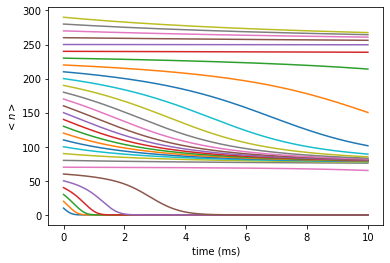

In [3]:
laser = pulse() 
N0 = np.arange(10, 300, 10)
for n0 in N0:
    t = trap(laser, N = 1000, n0 = int(n0), no_decay = True, ore = False, thermal_state = False)
    plot_matrix_method(laser, t, 'c')
plt.xlabel('time (ms)')
plt.ylabel('$< n >$')

<div style="background-color: #FFF8C6">
We can observe that there is trapping at around $n = 70$ and $n = 260$, and these to points match the minimum of the first red sideband for excitation wavelength of 729 nm.

**Plotting average phonon states versus time for different pulse lengths comparing Monte Carlo method with matrix methods. The initial Fock state was chosen to be 50.**

(0.0, 20.0)

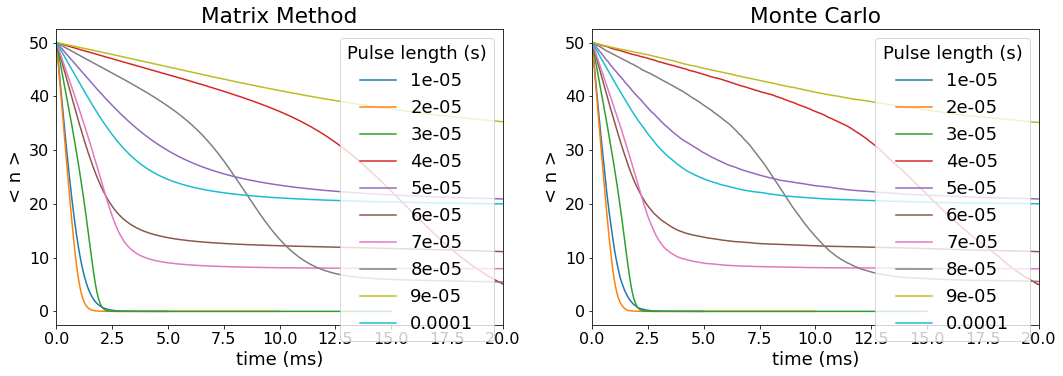

In [4]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8*2, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

pulse_time = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 10e-5]
# pulse_time = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4]

# matrix method 
plt.subplot(1,2,1)
for time in pulse_time:
    laser = pulse(pulse_length = time, wavelength = 729e-9, decay_wavelength = 379e-9, sideband = -1)
    t = trap(laser, N = 500, n0 = 50, no_decay = True, ore = False, thermal_state = False)
    plot_matrix_method(laser, t, 'a')

plt.legend(title = 'Pulse length (s)')
plt.title('Matrix Method')
plt.xlabel('time (ms)')
plt.ylabel('< n >')
plt.xlim(0, 20)

# Monte Carlo Method
plt.subplot(1,2,2)
for time in pulse_time:
    laser = pulse(pulse_length = time, wavelength = 729e-9, decay_wavelength = 379e-9, sideband = -1)
    t = trap(laser, N = 500, n0 = 50, no_decay = True, ore = False, M = 300, thermal_state = False)
    plot_ave(laser, t, 'a')

plt.legend(title = 'Pulse length (s)')
plt.title('Monte Carlo')
plt.xlabel('time (ms)')
plt.ylabel('< n >')
plt.xlim(0, 20)

<div style="background-color: #FFF8C6">
Comparing the two graphs, Matrix method and Monte Carlo methods give almost the same results, so we can conclude that results produced by Monte Carlo method averaged from 300 sets of realisations give reasonably good results.

(0.0, 20.0)

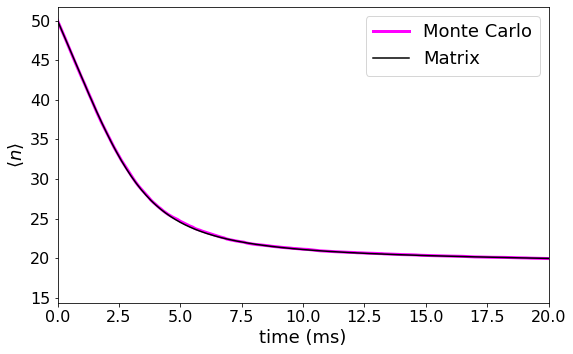

In [4]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)
laser = pulse(pulse_length = 10e-5, wavelength = L, decay_wavelength = LD, sideband = -1)
t = trap(laser, N = 500, n0 = 50, no_decay = True, ore = False, M = 300, thermal_state = False)
plot_ave(laser, t, 'b')
plot_matrix_method(laser, t, 'b')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel(r'$\langle n \rangle$')
plt.xlim(0, 20)

<div style="background-color: #FFF8C6">
Further compare the two methods by plotting them on the same plot, we can observe that both curves almost overlap. 

**Excited probability versus different pulse lengths, only tested the case when excited from n = 50 to n = 49.**

88914.06453459933
Amplitude = 0.49999999999999994, Frequency = 88914.06453459933, Phase shift = -1.5707963267948968, Offset = 0.5
Period = 1.1246814609525221e-05


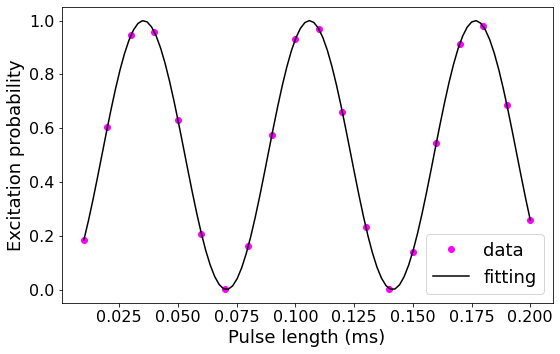

In [12]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

pulse_time = np.linspace(1e-5, 20e-5, 20)
Om_red = eff_rabi_freq(44, 43, freq_to_wav(729e-9, wz * (-1)), wz) * rb
print(Om_red)
for time in pulse_time:
    Red_prob = rabi_osci(time, Om_red, 1)
    if time == 1e-5:
        plt.plot(time*1e3, Red_prob,'o', color = 'magenta', label = 'data')
    else:
        plt.plot(time*1e3, Red_prob,'o', color = 'magenta')
        
def fit_function(x, a, b, c, d):
    return a * np.sin(b * x + d) + c

x = np.linspace(1e-5, 20e-5, num = 100)
p0 = [0.5, 0.7e5, 0.5, 10e-5] # initial guess
fit = curve_fit(fit_function, x, rabi_osci(x, Om_red, 1), p0=p0)
plt.plot(x*1e3, fit_function(x, *fit[0]), label='fitting', color = 'black')
plt.legend()
plt.xlabel('Pulse length (ms)')
plt.ylabel('Excitation probability')

print('Amplitude = %s, Frequency = %s, Phase shift = %s, Offset = %s' %(fit[0][0], fit[0][1], fit[0][3], fit[0][2]))
print('Period = %s' %(1/fit[0][1]))

**2D contour plot for excitation probability versus different pulse lengths and states.**

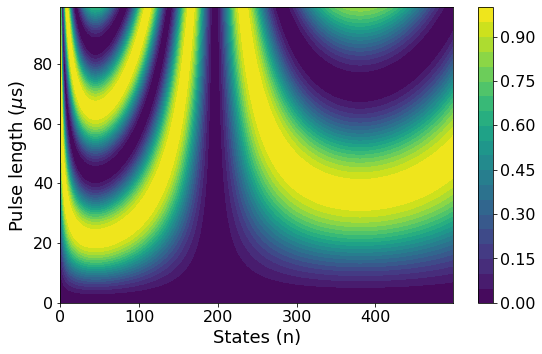

In [20]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

def excitation_probability(time, states):
    data = []
    for t in time:
        sub_data = []
        for n in states:
            Om_red = eff_rabi_freq(n, n-1, freq_to_wav(729e-9, wz * (-1)), wz)*rb
            sub_data.append(rabi_osci(t, Om_red, 1))
        data.append(sub_data)
    return data

pulse_time = [0, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 10e-5]
pulse_time = np.arange(0, 100, 1)*1e-6
states = np.arange(1, 501, 1)

Z = excitation_probability(pulse_time, states)

cs = plt.contourf(Z, levels = 20)
cs.changed()
plt.xlabel('States (n)')
plt.ylabel(r'Pulse length ($\mu$s) ')
plt.colorbar()

**Population distribution at the end of cooling.**

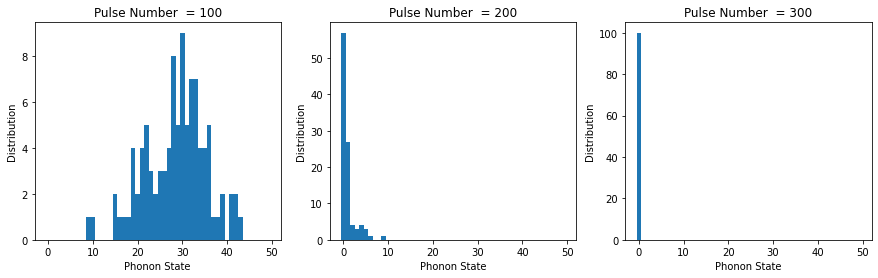

In [16]:
params = {
   'figure.figsize': [15, 4]
   } 
plt.rcParams.update(params)

laser = pulse()

t_100 = trap(laser, N = 100, n0 = 50, ore = False, no_decay = True, thermal_state = False)
plt.subplot(1,3,1)
plt.title('Pulse Number  = 100')
end_hist(laser, t_100)

t_200 = trap(laser, N = 200, n0 = 50, ore = False, no_decay = True, thermal_state = False)
plt.subplot(1,3,2)
plt.title('Pulse Number  = 200')
end_hist(laser, t_200)

t_300 = trap(laser, N = 300, n0 = 50, ore = False, no_decay = True, thermal_state = False)
plt.subplot(1,3,3)
plt.title('Pulse Number  = 300')
end_hist(laser, t_300)

plt.show()

<div style="background-color: #FFF8C6">
From the above three distributions, we can see that if apply enough pulses, all the populations will eventually go to ground state.

**Instead of starting from Fock state, now we start from a thermal distribution. Plotted with Monte Carlo method. An equivalent cooling dynamics from a Fock state (average of the Boltzman distribution) is also plotted for comparison.**

Initial temperature (theoretical): 0.0006775712274748934 K
Initial average n   (actual)     : 74.85


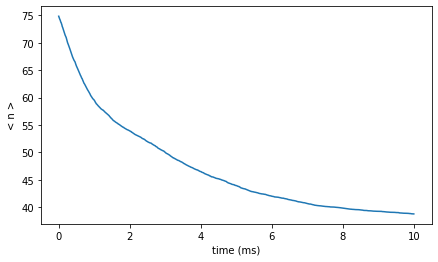

In [7]:
params = {
   'figure.figsize': [7, 4]
   } 
plt.rcParams.update(params)

laser = pulse()
N = Boltzmann_state(T = 1e-3, w = wz, size = 100)
t = trap(laser, N = 1000, n0 = 75, no_decay = True, ore = False, M = 100, thermal_state = True)
plot_ave(laser, t, 'c')

# new_n0 = np.average(N)
# t_fock = trap(laser, N = 500, n0 = int(new_n0), no_decay = True)
# plot_ave(laser, t_fock, 'c')

plt.xlabel('time (ms)')
plt.ylabel('< n >')
#plt.legend()
plt.show()

# plt.hist(N)
# plt.xlabel('Initial states n')
# plt.ylabel('Count')

Initial temperature (theoretical): 0.0004621765818340266 K
Initial average n   (actual)     : 50.54


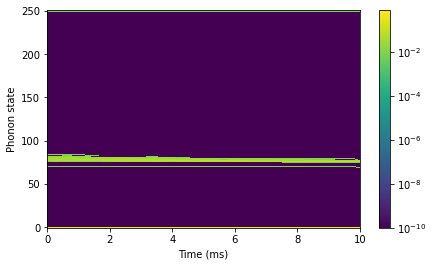

In [16]:
laser = pulse()
t = trap(laser, N = 1000, n0 = 51, no_decay = True, ore = False, M = 100, thermal_state = True)
a, b = t.sideband_cool_sch(laser)
twod_traj2(laser, t, logplot = True)

### Case II - Decay considered, off-resonant excitation not considered <a id="s_case2"></a>

In the following plots, we have assumed:
1. Infinitely short excited state lifetime
3. Excitation through first red sideband only
2. Allow decay to other sidebands 

Text(0.5, 1.0, 'Excitation wavelength = 729 nm')

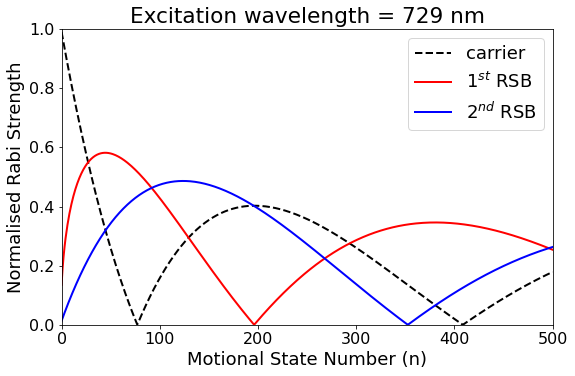

In [78]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

sb = 2
n0 = 500
Om_list = [[] for _ in range(sb+1)]
# Om_list[0] = carrier, Om_list[1] = red 1, Om_list[2] = red 2, ...
for i in range(0, n0+1):
    Om_list[0].append(eff_rabi_freq(i, i, L, wz))
    for j in range(1, sb+1):
        Om_list[j].append(eff_rabi_freq(i, i+j, freq_to_wav(L, -wz), wz))
# return Om_list
plt.plot(Om_list[0], '--', color = 'black', linewidth = 2, label = 'carrier')
plt.plot(Om_list[1], color = 'red', linewidth = 2, label = '$1^{st}$ RSB')
plt.plot(Om_list[2], color = 'blue', linewidth = 2, label = '$2^{nd}$ RSB')

plt.legend()
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xlabel('Motional State Number (n)')
plt.ylabel('Normalised Rabi Strength')
plt.title('Excitation wavelength = %s nm'%(int(l*1e9)))

Text(0.5, 1.0, 'Decay wavelength = 397 nm')

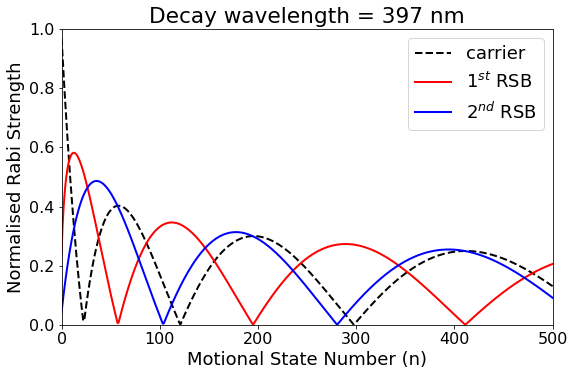

In [5]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

sb = 2
n0 = 500
Om_list = [[] for _ in range(sb+1)]
# Om_list[0] = carrier, Om_list[1] = red 1, Om_list[2] = red 2, ...
for i in range(0, n0+1):
    Om_list[0].append(eff_rabi_freq(i, i, LD, wz))
    for j in range(1, sb+1):
        Om_list[j].append(eff_rabi_freq(i, i+j, freq_to_wav(LD, 0), wz))
# return Om_list
plt.plot(Om_list[0], '--', color = 'black', linewidth = 2, label = 'carrier')
plt.plot(Om_list[1], color = 'red', linewidth = 2, label = '$1^{st}$ RSB')
plt.plot(Om_list[2], color = 'blue', linewidth = 2, label = '$2^{nd}$ RSB')

plt.legend()
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xlabel('Motional State Number (n)')
plt.ylabel('Normalised Rabi Strength')
plt.title('Decay wavelength = %s nm'%(int(LD*1e9)))

Excitation wavelength
state = 60,  carrier strength = 0.154, 1 RSB strength = 0.567, 2 RSB strength = 0.376
state = 61,  carrier strength = 0.144, 1 RSB strength = 0.565, 2 RSB strength = 0.379
state = 62,  carrier strength = 0.134, 1 RSB strength = 0.563, 2 RSB strength = 0.383
state = 63,  carrier strength = 0.124, 1 RSB strength = 0.561, 2 RSB strength = 0.387
state = 64,  carrier strength = 0.115, 1 RSB strength = 0.558, 2 RSB strength = 0.390
state = 65,  carrier strength = 0.105, 1 RSB strength = 0.556, 2 RSB strength = 0.393
state = 66,  carrier strength = 0.096, 1 RSB strength = 0.553, 2 RSB strength = 0.397
state = 67,  carrier strength = 0.087, 1 RSB strength = 0.551, 2 RSB strength = 0.400
state = 68,  carrier strength = 0.078, 1 RSB strength = 0.548, 2 RSB strength = 0.403
state = 69,  carrier strength = 0.069, 1 RSB strength = 0.546, 2 RSB strength = 0.406
state = 70,  carrier strength = 0.060, 1 RSB strength = 0.543, 2 RSB strength = 0.409
state = 71,  carrier strength = 

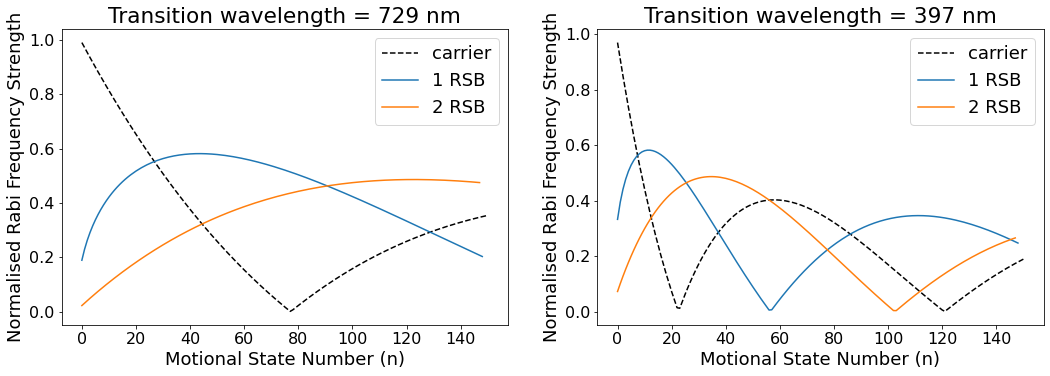

In [8]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8*2, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

plt.subplot(1, 2, 1)
PlotRedSb(n0 = 150, sb = 2, l = L)

plt.subplot(1, 2, 2)
PlotRedSb(n0 = 150, sb = 2, l = LD)

print('Excitation wavelength')
for state in range(60, 81):
    print('state = %s,  carrier strength = %.3f, 1 RSB strength = %.3f, 2 RSB strength = %.3f'
          %(state, eff_rabi_freq(state, state, L, wz), eff_rabi_freq(state, state - 1, L, wz), eff_rabi_freq(state, state - 2, L, wz)))

print('Decay wavelength')
for state in range(60, 81):
    print(('state = %s,  carrier strength = %.3f, 1 RSB strength = %.3f, 2 RSB strength = %.3f'
          %(state, eff_rabi_freq(state, state, LD, wz), eff_rabi_freq(state, state - 1, LD, wz), eff_rabi_freq(state, state - 2, LD, wz))))


**Plotting averaged phonon states versus time, comparing matrix method and Monte Carlo method. Initial Fock states from n = 10 to n = 300 were tested. Allow decays to n $\pm$ 1 states.**

Text(0, 0.5, '< n >')

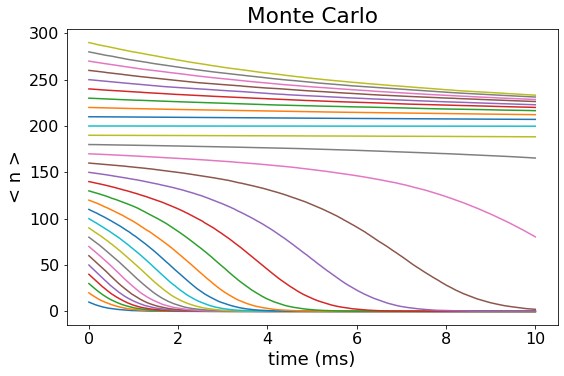

In [11]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

laser = pulse(pulse_length = 1e-5, wavelength = 729e-9, decay_wavelength = 379e-9, sideband = -1)
N0 = np.arange(10, 300, 10)

# matrix method 
# plt.subplot(1,2,1)
# for n0 in N0:
    # t = trap(laser, N = 1000, n0 = int(n0), no_decay = False, ore = False, sideband = 1, thermal_state = False)
    # plot_matrix_method(laser, t, 'c')

# plt.title('Matrix Method')
# plt.xlabel('time (ms)')
# plt.ylabel('< n >')

# Monte Carlo Method
# plt.subplot(1,2,2)
for n0 in N0:
    t = trap(laser, N = 1000, M = 300, n0 = int(n0), no_decay = False, ore = False, sideband = 1, thermal_state = False)
    plot_ave(laser, t, 'c')

plt.title('Monte Carlo')
plt.xlabel('time (ms)')
plt.ylabel('< n >')

**Distribution at the end of cooling, with decay to n $\pm$ 1 taking into account.**

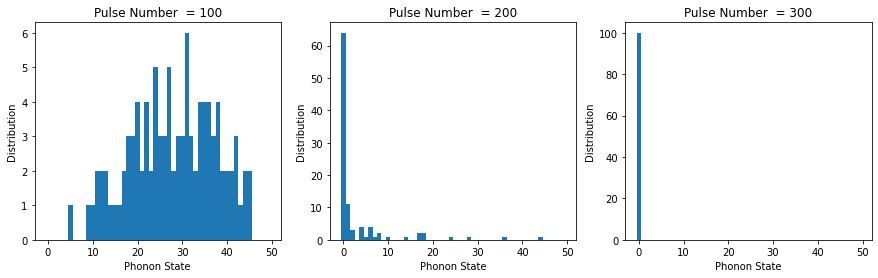

In [5]:
params = {
   'figure.figsize': [15, 4]
   } 
plt.rcParams.update(params)

laser = pulse()

t_decay_100 = trap(laser, N = 100, n0 = 50, no_decay = False, ore = False, sideband = 1, thermal_state = False)
plt.subplot(1,3,1)
plt.title('Pulse Number  = 100')
end_hist(laser, t_decay_100)

t_decay_200 = trap(laser, N = 200, n0 = 50, no_decay = False, ore = False, sideband = 1, thermal_state = False)
plt.subplot(1,3,2)
plt.title('Pulse Number  = 200')
end_hist(laser, t_decay_200)

t_decay_300 = trap(laser, N = 300, n0 = 50, no_decay = False, ore = False, sideband = 1, thermal_state = False)
plt.subplot(1,3,3)
plt.title('Pulse Number  = 300')
end_hist(laser, t_decay_300)

plt.show()

**Plotting averaged phonon states versus time comparing Monte Carlo and matrix method. Initial Fock states from n = 10 to n = 300 were tested. Allow decays to n $\pm$ 2 states.**

Text(0.5, 1.0, 'Monte Carlo Method')

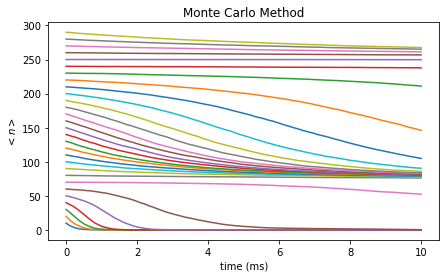

In [2]:
params = {
   # 'figure.figsize': [14, 4]
    'figure.figsize': [7, 4]
   } 
plt.rcParams.update(params)

laser = pulse()
N0 = np.arange(10, 300, 10)

# plt.subplot(1, 2, 1)
# for n0 in N0:
    # t = trap(laser, N = 1000, n0 = int(n0), no_decay = False, ore = False, sideband = 2, M = 200, thermal_state = False)
    # plot_matrix_method(laser, t, 'c')
# plt.xlabel('time (ms)')
# plt.ylabel('$< n >$')
# plt.title('Matrix Method')

# Monte Carlo method
# plt.subplot(1, 2, 2)
for n0 in N0:
    t = trap(laser, N = 1000, n0 = n0, no_decay = False, ore = False, sideband = 2, M = 200, thermal_state = False)
    plot_ave(laser, t, 'c')
plt.xlabel('time (ms)')
plt.ylabel('$< n >$')
plt.title('Monte Carlo Method')

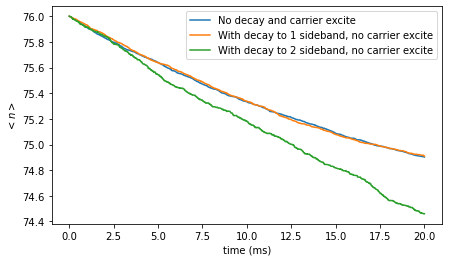

In [9]:
params = {
   'figure.figsize': [7, 4]
   } 
plt.rcParams.update(params)

laser = pulse()
t_0 = trap(laser, N = 2000, n0 = 76, no_decay = True, ore = False, sideband = 0, M = 1000, thermal_state = False)
plot_ave(laser, t_0, 'd')
t_1 = trap(laser, N = 2000, n0 = 76, no_decay = False, ore = False, sideband = 1, M = 1000, thermal_state = False)
plot_ave(laser, t_1, 'd')
t_2 = trap(laser, N = 2000, n0 = 76, no_decay = False, ore = False, sideband = 2, M = 1000, thermal_state = False)
plot_ave(laser, t_2, 'd')

plt.xlabel('time (ms)')
plt.ylabel('$< n >$')
plt.legend()

<div style="background-color: #FFF8C6">
In principle, decay through second sideband can overcome the minimum. For example, at $n = 74$. 
    
$n = 75$  --excite-->  $n = 74$  --decay-->  $n = 72$


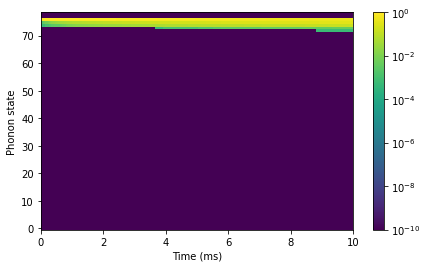

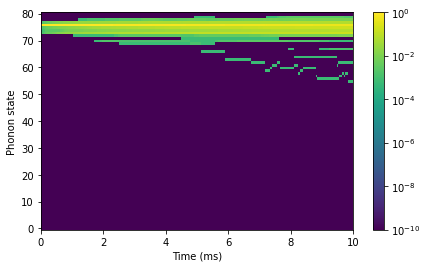

In [3]:
params = {
   'figure.figsize': [7, 4]
   } 
plt.rcParams.update(params)
laser = pulse()

t1 = trap(laser, N = 1000, n0 = 76, M = 1500, no_decay = False, ore = False, sideband = 1, thermal_state = False)
twod_traj2(laser, t1, logplot = True)

t2 = trap(laser, N = 1000, n0 = 76, M = 1500, no_decay = False, ore = False, sideband = 2, thermal_state = False)
twod_traj2(laser, t2, logplot = True)


### Case III - Decay and off-resonant excitation considered <a id="s_case3"></a>

In the following plots, we have assumed:
1. Infinitely short excited state lifetime
3. Excitation can take place through first red sideband and carrier 
2. Allow decay to other sidebands 

**Comparison among different conditions:**
1. Decay and off-resonant carrier excitation are not considered 
2. Decay is considered, but off-resonant carrier excitation is not considered 
3. Both decay and off-resonant carrier excitation are considered

In [7]:
params = {
   'figure.figsize': [7, 4]
   } 
plt.rcParams.update(params)
laser = pulse()

**Averaged phonon state versus time for different scenarios. Started from initial Fock state $n_{0} = 50$**

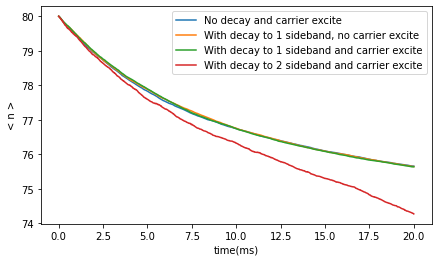

In [8]:

t1 = trap(laser, N = 2000, n0 = 80, M = 1500, no_decay = True, ore = False, sideband = 1, thermal_state = False)
t2 = trap(laser, N = 2000, n0 = 80, M = 1500, no_decay = False, ore = False, sideband = 1, thermal_state = False)
t3 = trap(laser, N = 2000, n0 = 80, M = 1500, no_decay = False, ore = True, sideband = 1, thermal_state = False)
t4 = trap(laser, N = 2000, n0 = 80, M = 1500, no_decay = False, ore = True, sideband = 2, thermal_state = False)

plot_ave(laser, t1, 'd')
plot_ave(laser, t2, 'd')
plot_ave(laser, t3, 'd')
plot_ave(laser, t4, 'd')

plt.xlabel('time(ms)')
plt.ylabel('< n >')
plt.legend()

**Averaged phonon state versus time for different scenarios. Started from initial Fock state $n_{0} = 80$**

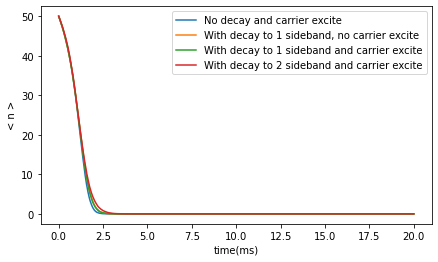

In [12]:
laser = pulse()

t1 = trap(laser, N = 2000, n0 = 50, M = 1500, no_decay = True, ore = False, sideband = 1, thermal_state = False)
t2 = trap(laser, N = 2000, n0 = 50, M = 1500, no_decay = False, ore = False, sideband = 1, thermal_state = False)
t3 = trap(laser, N = 2000, n0 = 50, M = 1500, no_decay = False, ore = True, sideband = 1, thermal_state = False)
t4 = trap(laser, N = 2000, n0 = 50, M = 1500, no_decay = False, ore = True, sideband = 2, thermal_state = False)

plot_ave(laser, t1, 'd')
plot_ave(laser, t2, 'd')
plot_ave(laser, t3, 'd')
plot_ave(laser, t4, 'd')

plt.xlabel('time(ms)')                                                                                    
plt.ylabel('< n >')
plt.legend()

**Population distribution over time comparing off-resonant excitation (top) with no off-resonant excitation (bottom). Decays through carrier, first sidebands, and second sidebands are allowed. Starting from initial Fock state $n_{0}=50$, 500 pulses were applied, averaged from 1500 realisations.**

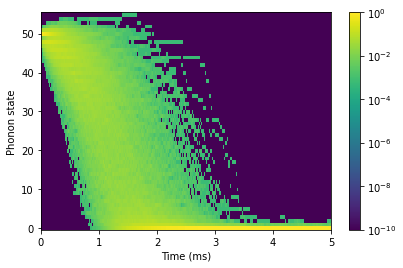

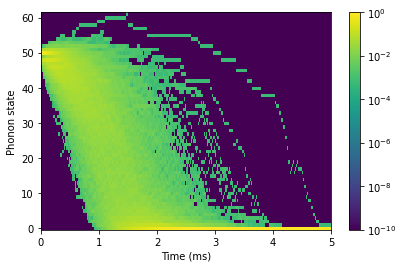

In [3]:
params = {
   'figure.figsize': [6.5, 4]
   } 
plt.rcParams.update(params)
laser = pulse()

t = trap(laser, N = 500, n0 = 50, M = 1500, no_decay = False, ore = True, sideband = 2, thermal_state = False)
twod_traj2(laser, t, logplot = True)

t2 = trap(laser, N = 500, n0 = 50, M = 1500, no_decay = False, ore = False, sideband = 2, thermal_state = False)
twod_traj2(laser, t2, logplot = True)

After Doppler cooling, the ion population is in a thermal state described by a Bolzmann distribution of mean $\bar{n}$ with a occupation probability given by 

$P(n)=\frac{\bar{n}^{n}}{(\bar{n}+1)^{n+1}}$

**Population distribution overtime for initial thermal distribution. Off-resonant carrier excitation as well as decays through carrier, first sidebands, and second sidebands were enabled.**

Initial temperature (theoretical): 0.0004532017097007217 K
Initial average n   (actual)     : 50.21333333333333


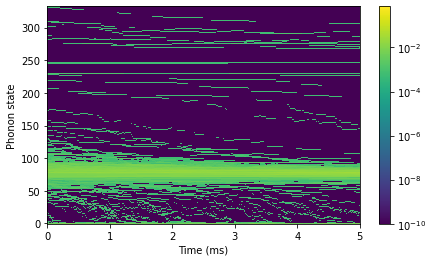

In [19]:
laser = pulse()
t = trap(laser, N = 500, n0 = 50, no_decay = False, ore = True, sideband = 2, M = 1500, thermal_state = True)
a, b = t.sideband_cool_sch(laser)
twod_traj2(laser, t, logplot = True)

## Cooling Two Ions <a id="two"></a>

The LD parameters correspondind to the normal modes of a two-ion crystal differ from the single-ion one due to the difference in the collective mass of the crystal and the collective motional frequencies. 

**For two-ion string**
- $\omega_{COM} = \omega_{z}$ ----> $\eta_{COM} = \frac{\eta_{0}}{\sqrt{2}}$
- $\omega_{B} = \sqrt{3}\omega_{z}$ ----> $\eta_{B} = \frac{\eta_{0}}{\sqrt{2\sqrt{3}}}$

**For planar crystal**
- $\omega_{COM} = \omega_{z}$ ----> $\eta_{COM} = \frac{\eta_{0}}{\sqrt{2}}$
- $\omega_{tilt} = \sqrt{\omega_{z}^{2} - \omega_{eff}^{2}}$ ----> $\eta_{tilt} \approx \frac{\eta_{0}}{\sqrt{2}}$

The Rabi frequency of the motional excitation for both of the motional modes is written as 

$\Omega_{n, n^{\prime}, m, m^{\prime}}=\Omega_{0} \cdot \tilde{\Omega}_{n, n^{\prime}} \cdot \tilde{\Omega}_{m, m^{\prime}}$

where  $\tilde{\Omega}_{n, n^{\prime}}/\Omega_{0}$ and $\tilde{\Omega}_{m, m^{\prime}}/\Omega_{0}$ are the normalized Rabi strengths of the transition from COM motional state $n$ to $n'$ and breathing/tilt motional state $m$ to $m'$.

**Strength of various sidebands as a function of phonon number for a two-ion string at 187kHz motional frequency and excitation wavelength (729nm)**

Text(0.5, 1.0, 'COM 3 RSB')

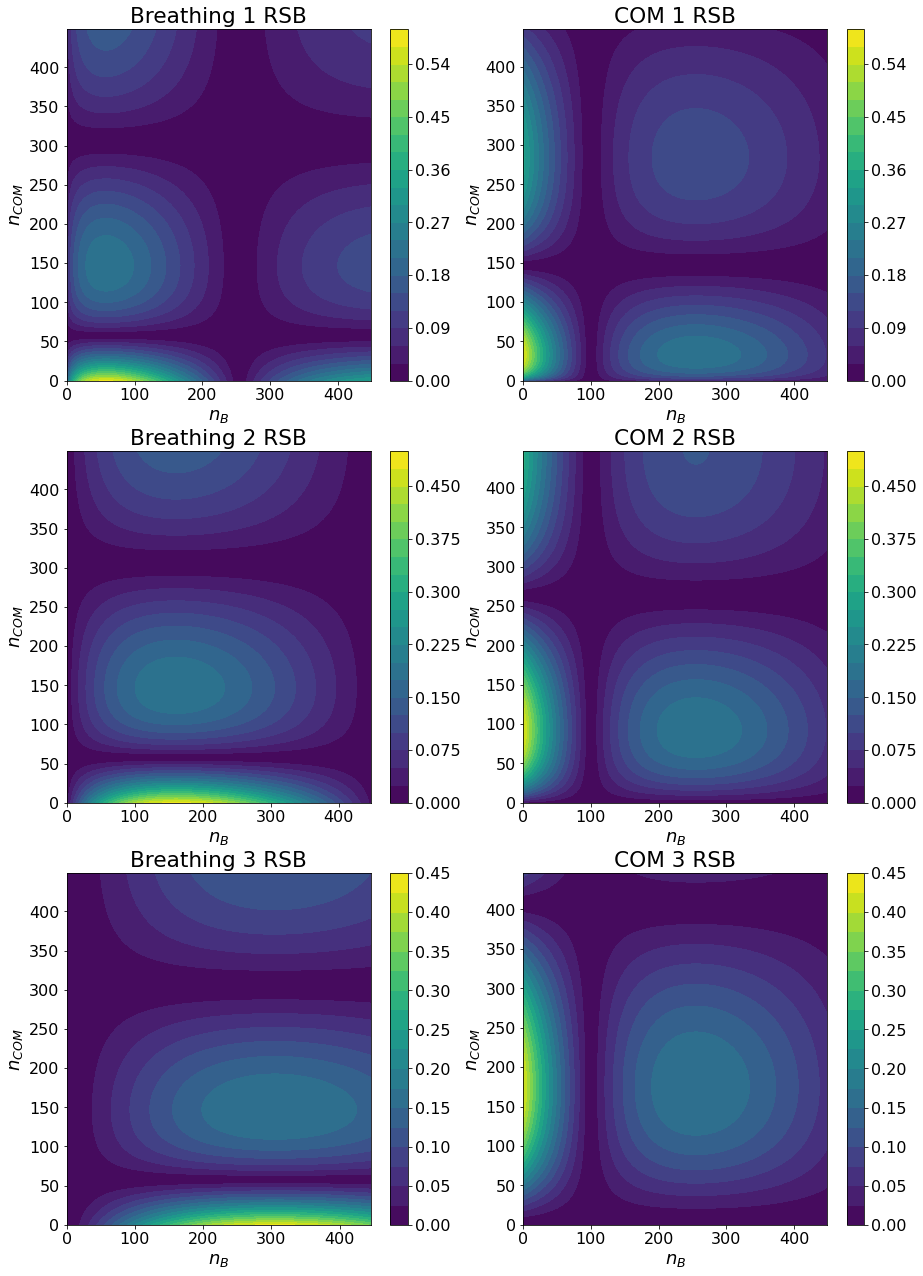

In [26]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [15, 22] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

plt.subplot(3, 2, 1)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = 0, band_b = -1, wavelength = L)
plt.title('Breathing 1 RSB')

plt.subplot(3, 2, 2)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -1, band_b = 0, wavelength = L)
plt.title('COM 1 RSB')

plt.subplot(3, 2, 3)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = 0, band_b = -2, wavelength = L)
plt.title('Breathing 2 RSB')

plt.subplot(3, 2, 4)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -2, band_b = 0, wavelength = L)
plt.title('COM 2 RSB')\

plt.subplot(3, 2, 5)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = 0, band_b = -3, wavelength = L)
plt.title('Breathing 3 RSB')

plt.subplot(3, 2, 6)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -3, band_b = 0, wavelength = L)
plt.title('COM 3 RSB')


In [1]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [15, 22] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

plt.subplot(3, 2, 1)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -1, band_b = -1, wavelength = L)
plt.title('Breathing + COM 1 RSB')

plt.subplot(3, 2, 2)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -1, band_b = -2, wavelength = L)
plt.title('Breathing 2 RSB + COM 1 RSB')

plt.subplot(3, 2, 3)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -2, band_b = -2, wavelength = L)
plt.title('Breathing + COM 2 RSB')

plt.subplot(3, 2, 4)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -2, band_b = -1, wavelength = L)
plt.title('Breathing 1 RSB + COM 2 RSB')
"""
plt.subplot(3, 2, 5)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -3, band_b = -2, wavelength = L)
plt.title('Breathing 2 RSB + COM 3 RSB')

plt.subplot(3, 2, 6)
plot_twoD_rabi_strength(n_com = 450, n_b = 450, band_com = -3, band_b = -1, wavelength = L)
plt.title('Breathing 1 RSB + COM 3 RSB')
"""

NameError: name 'plt' is not defined

- (a) 1 RSB of breathing mode, carrier of COM mode
- (b) Carrier of breathing mode, 1 RSB of COM mode
- (c) 2 RSB of breathing mode, carrier of COM mode
- (d) Carrier of breathing mode, 2 RSB of COM mode
- (e) Carrier of breathing mode, 3 RSB of COM mode
- (f) 1 RSB of breathing mode, 2 RSB of COM mode

 To find the time evolution of the population between the internal and external states of two ions, we first assume the basis vectors for the blue sideband for the COM motion (denoted by $n$, while breathing mode is denoted by $k$) are $\left|g_{1}, g_{2}, n, k\right\rangle,\left|e_{1}, g_{2}, n+1, k\right\rangle,\left|g_{1}, e_{2}, n+1, k\right\rangle$ and $\left|e_{1}, e_{2}, n+2, k\right\rangle$, then the wavefunction for the blue sideband is defined as [JoshiThesis]
 
 $|\psi\rangle_{blue}=C_{1}\left|g_{1}, g_{2}, n, k\right\rangle+C_{2}\left|e_{1}, g_{2}, n+1, k\right\rangle+C_{3}\left|g_{1}, e_{2}, n+1, k\right\rangle+C_{4}\left|e_{1}, e_{2}, n+2, k\right\rangle$, 
 
 and similarly the wavefunction for the red sideband is defined as 
 
 $|\psi\rangle_{red}=D_{1}\left|g_{1}, g_{2}, n, k\right\rangle+D_{2}\left|e_{1}, g_{2}, n-1, k\right\rangle+D_{3}\left|g_{1}, e_{2}, n-1, k\right\rangle+D_{4}\left|e_{1}, e_{2}, n-2, k\right\rangle$.
 

<span style="color:red">Since the sideband transitions affect the motional state, which is a shared property of both ions, such transitions produce entanglement between the ions' spins and their collective motion [King98]. If we try to drive the red or blue sideband of one mode, the excitation probability of one ion is conditional on the excitation of the other since the motional state and hence coupling strength changes as soon as one ion spin is flipped, this results in a weak form of **spin-motion entanglement**.</span> The interaction Hamiltonian is given by [HrmoThesis]

$\hat{H}_{I}=\frac{\hbar \Omega}{2} \sum_{n, n, k^{\prime}, k} \sum_{j=1}^{2} \sigma_{+}^{(j)} e^{-i \delta t}\left[\left|n^{\prime}\right\rangle\left\langle n^{\prime}\left|e^{-i \eta_{c}\left(\tilde{a}^{\dagger}+\tilde{a}\right)}\right| n\right\rangle\left\langle n|| k^{\prime}\right\rangle\left\langle k^{\prime}\left|e^{-i(-1)^{j} \eta_{b}\left(\tilde{b}^{\dagger}+\tilde{b}\right)}\right| k\right\rangle\langle k|\right]+h . c $,

replacing the middle part by $\Omega_{n^{\prime}, n} e^{-i \Delta n \omega_{z}} \times \Omega_{k^{\prime}, k} e^{-i \Delta k \omega_{b}}$, where $\Omega_{n^{\prime}, n}$ and $\Omega_{k^{\prime}, k}$ are defined as the normalised Rabi strengths for the respective sidebands. The interaction Hamiltonian can then be further simplified to 

$\hat{H}_{I}=\frac{\hbar \Omega}{2} \sum_{j=1}^{2} \sigma_{+}^{(j)} e^{-i \delta t}\left[\left|n^{\prime}\right\rangle\left\langle n\left|\Omega_{n^{\prime}, n} e^{-i \Delta n \omega_{z}}\right| k^{\prime}\right\rangle\langle k| \Omega_{k^{\prime}, k} e^{-i \Delta k \omega_{B}}(-1)^{j}\right]+h . c .$

where $\Delta n=n^{\prime}-n$ and $\Delta n=n^{\prime}-n$. Additionally, $\sigma_{+} = |e\rangle\langle g|$ and $\sigma_{-} = |g\rangle\langle e|$ are Pauli spin matrices. Writing the interaction Hamiltonian in matrix form we have for the blue and red sidebands:

$H_{b, n}=\frac{i \eta_{n} \hbar \Omega_{0}}{2}\left[\begin{array}{cccc}
0 & -e^{-i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{2+n} & -e^{-i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{2+n} & 0 \\
e^{i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{2+n} & 0 & 0 & -e^{-i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{1+n} \\
e^{i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{2+n} & 0 & 0 & -e^{-i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{1+n} \\
0 & e^{i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{1+n} & e^{i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{1+n} & 0
\end{array}\right]$

$H_{r, n}=i \eta_{n} \frac{\hbar \Omega_{0}}{2}\left[\begin{array}{cccc}
0 & -e^{-i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{n-1} & -e^{-i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{n-1} & 0 \\
e^{i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{n-1} & 0 & 0 & -e^{-i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{n} \\
e^{i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{n-1} & 0 & 0 & -e^{-i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{n} \\
0 & e^{i\left(\Delta_{2} t+\phi_{2}\right)} \sqrt{n} & e^{i\left(\Delta_{1} t+\phi_{1}\right)} \sqrt{n} & 0
\end{array}\right]$

After solving the time-dependent Schrodinger's equation, the wavefunction for two ions starting in the state $\left|g_{1}, g_{2}, n, k\right\rangle$ and driven for time $t$ by laser field resonant with the blue sideband and red sideband for COM mode are [HomeThesis] 

$\begin{aligned}
\left|\psi\right\rangle_{b,CoM} &= e^{-i\left(\phi_{1}+\phi_{2}\right)} \frac{\sqrt{(n+1)(n+2)}}{2 n+3}\left(1-\cos \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{c} t\right)\right)|e_{1}, e_{2}, n+2, k\rangle \\
& + e^{-i \phi_{2}} \sqrt{\frac{n+1}{2(2 n+3)}} \sin \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{c} t\right)|e_{1}, g_{2}, n+1, k\rangle\\
& +e^{-i \phi_{1}} \sqrt{\frac{n+1}{2(2 n+3)}} \sin \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{c} t\right)|g_{1}, e_{2}, n+1, k\rangle \\
& +\left[1+\frac{n+1}{2 n+3}\left(1-\cos \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{c} t\right)\right)\right]|g_{1}, g_{2}, n, k\rangle,
\end{aligned}$

and 

$\begin{aligned}
\left|\psi\right\rangle_{r, CoM} &= e^{-i\left(\phi_{1}+\phi_{2}\right)} \frac{\sqrt{n(n-1)}}{2 n-1}\left(1-\cos \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{c} t\right)\right)|e_{1}, e_{2}, n-2, k\rangle \\
& + e^{-i \phi_{2}} \sqrt{\frac{n}{2(2 n-1)}} \sin \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{c} t\right)|e_{1}, g_{2}, n-1, k\rangle\\
& +e^{-i \phi_{1}} \sqrt{\frac{n}{2(2 n-1)}} \sin \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{c} t\right)|g_{1}, e_{2}, n-1, k\rangle \\
& +\left[1-\frac{n}{2 n-1}\left(1-\cos \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{c} t\right)\right)\right]|g_{1}, g_{2}, n, k\rangle,
\end{aligned}$

where $\Omega_{c} = \eta_{c} \Omega_{0}$. 

Similarly, the wavefunction for two ions starting in the state $\left|g_{1}, g_{2}, n, k\right\rangle$ and driven for time $t$ by laser field resonant with the blue sideband and red sideband for breathing mode are  

$\begin{aligned}
\left|\psi\right\rangle_{b,breathing} &= - e^{-i\left(\phi_{1}+\phi_{2}\right)} \frac{\sqrt{(n+1)(n+2)}}{2 n+3}\left(1-\cos \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{b} t\right)\right)|e_{1}, e_{2}, n, k+2\rangle \\
& - e^{-i \phi_{2}} \sqrt{\frac{n+1}{2(2 n+3)}} \sin \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{b} t\right)|e_{1}, g_{2}, n, k+1 \rangle\\
& + e^{-i \phi_{1}} \sqrt{\frac{n+1}{2(2 n+3)}} \sin \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{b} t\right)|g_{1}, e_{2}, n, k+1 \rangle \\
& +\left[1+\frac{n+1}{2 n+3}\left(1-\cos \left(\sqrt{\frac{(2n+3)}{2}} \Omega_{b} t\right)\right)\right]|g_{1}, g_{2}, n, k\rangle,
\end{aligned}$

and 

$\begin{aligned}
\left|\psi\right\rangle_{r, breathing} &= - e^{-i\left(\phi_{1}+\phi_{2}\right)} \frac{\sqrt{n(n-1)}}{2 n-1}\left(1-\cos \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{b} t\right)\right)|e_{1}, e_{2}, n, k-2\rangle \\
& - e^{-i \phi_{2}} \sqrt{\frac{n}{2(2 n-1)}} \sin \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{b} t\right)|e_{1}, g_{2}, n, k-1\rangle\\
& + e^{-i \phi_{1}} \sqrt{\frac{n}{2(2 n-1)}} \sin \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{b} t\right)|g_{1}, e_{2}, n, k-1\rangle \\
& +\left[1-\frac{n}{2 n-1}\left(1-\cos \left(\sqrt{\frac{(2n-1)}{2}} \Omega_{b} t\right)\right)\right]|g_{1}, g_{2}, n, k\rangle,
\end{aligned}$

where $\Omega_{b} = \eta_{b} \Omega_{0}$. 

Calculating $P_{e}=|e g|^{2}+|e e|^{2}$ for one ion and $P_{e}=|g e|^{2}+|e e|^{2}$ for the other. The above dynamics are only suitable for up to $n = 4$. For a complete range of state, need to contruct the full Hamiltonian and solve the Schrodinger's equation. 

<span style="color:red">Outside the Lamb-Dicke regime</span>, the entanglement becomes negligible and the excitation on each sideband is well approximated by a single ion line shape with the correct $\Omega_{n, n^{\prime}, k, k^{\prime}}$ Rabi frequency. For a thermally distributed state we then get an excitation lineshape on a single ion:

$P_{e}=\sum_{k=0}^{\infty} \sum_{n=0}^{\infty} \frac{\bar{n}^{n}}{(\bar{n}+1)^{n+1}} \frac{\bar{k}^{k}}{(\bar{k}+1)^{k+1}} \frac{\Omega_{n, k, n^{\prime}, k^{\prime}}^{2}}{\Omega_{n, k, n^{\prime}, k^{\prime}}^{2}+\Delta^{2}} \sin ^{2}\left(\frac{\sqrt{\Omega_{n, k, n^{\prime}, k^{\prime}}^{2}+\Delta^{2}}}{2} t\right).$

Foa a double excitation, this expression is simply multiplied by the excitation lineshape of the other ion.

In [2]:
all_rabi_strength = pickle.load(open('test', 'rb'))
#print(all_rabi_strength)

Text(0.5, 1.0, 'Breathing 1 RSB')

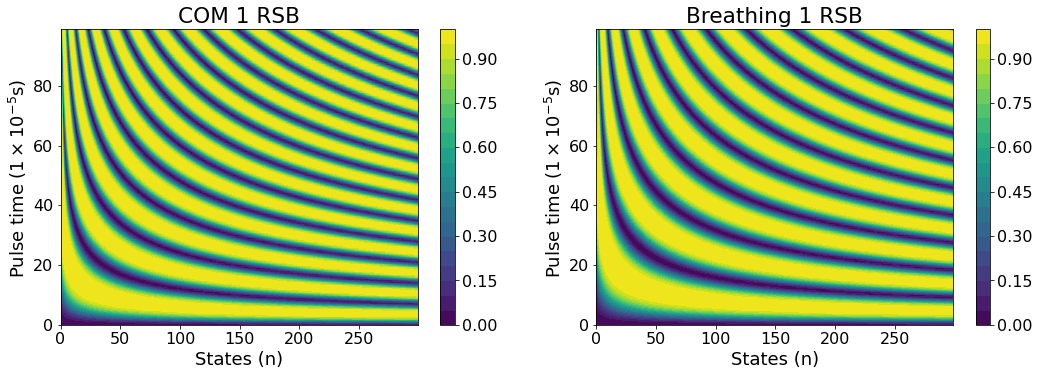

In [5]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8*2, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

def twoD_Contour_74(com_s, b_s, pulse_time, states):
    all_rabi_strength = pickle.load(open('test2', 'rb'))
    R_com = all_rabi_strength[-com_s]
    R_b = all_rabi_strength[-b_s]

    eta_c = LambDicke(freq_to_wav(L, wz * com_s), wz)/np.sqrt(2) # LD param for COM mode
    eta_b = LambDicke(freq_to_wav(L, wz * b_s), wz)/np.sqrt(2*np.sqrt(3)) # LD param for breathing mode
                      
    def excitation_probability(time, state):
        data = []
        for t in time:
            sub_data = []
            for n in state:
                if com_s:
                    ee, eg, gg = excitation_prob(n, rb*eta_c, t)
                if b_s:
                    ee, eg, gg = excitation_prob(n, rb*eta_b, t)
                sub_data.append(ee + eg)
            data.append(sub_data)
        return data

    Z = excitation_probability(pulse_time, states)
    
    cs = plt.contourf(Z, levels = 20)
    cs.changed()
    plt.xlabel('States (n)')
    plt.ylabel(r'Pulse time ($1\times 10^{-5}$s) ')
    plt.colorbar()

pulse_time = np.arange(1, 15, 1)*1e-5
states_74 = np.arange(1, 301, 1)

plt.subplot(1, 2, 1)
twoD_Contour_74(-1, 0, pulse_time_74, states_74) 
plt.title('COM 1 RSB')
plt.subplot(1, 2, 2)
twoD_Contour_74(0, -1, pulse_time_74, states_74) 
plt.title('Breathing 1 RSB')

Text(0.5, 1.0, 'COM 3 RSB')

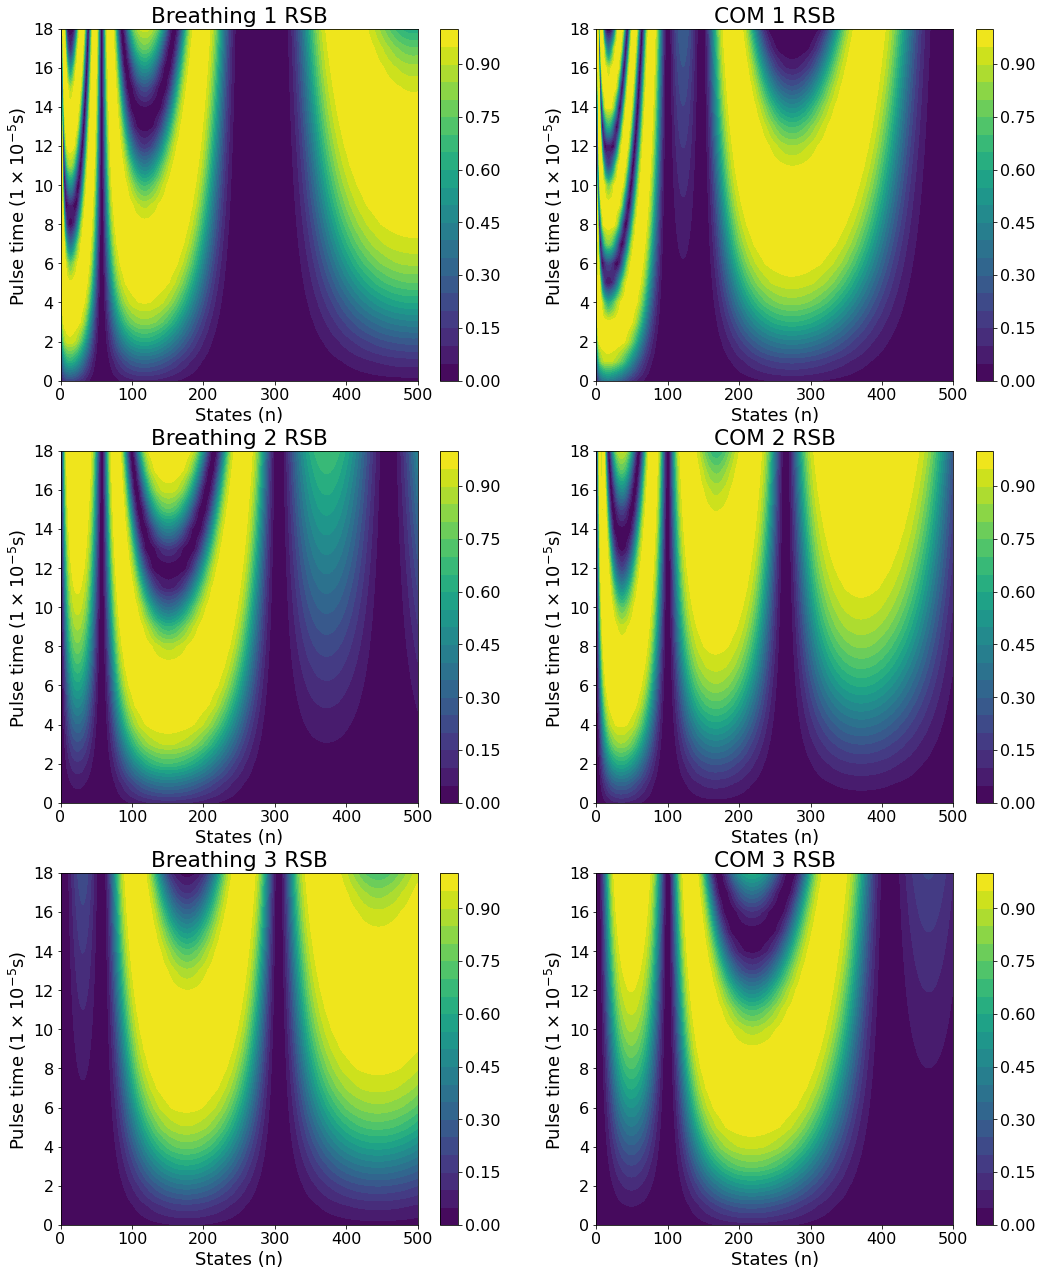

In [5]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8*2, 8.8*2.5] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

pulse_time = np.arange(1, 20, 1)*1e-5
states = np.arange(0, 501, 1)

plt.subplot(3, 2, 2)
twoD_Contour([-1, 0], pulse_time, states)
plt.title('COM 1 RSB')

plt.subplot(3, 2, 1)
twoD_Contour([0, -1], pulse_time, states)
plt.title('Breathing 1 RSB')

plt.subplot(3, 2, 3)
twoD_Contour([0, -2], pulse_time, states)
plt.title('Breathing 2 RSB')

plt.subplot(3, 2, 4)
twoD_Contour([-2, 0], pulse_time, states)
plt.title('COM 2 RSB')

plt.subplot(3, 2, 5)
twoD_Contour([0, -3], pulse_time, states)
plt.title('Breathing 3 RSB')

plt.subplot(3, 2, 6)
twoD_Contour([-3, 0], pulse_time, states)
plt.title('COM 3 RSB')

Text(0.5, 1.0, 'Breathing 1 RSB + COM 3 RSB')

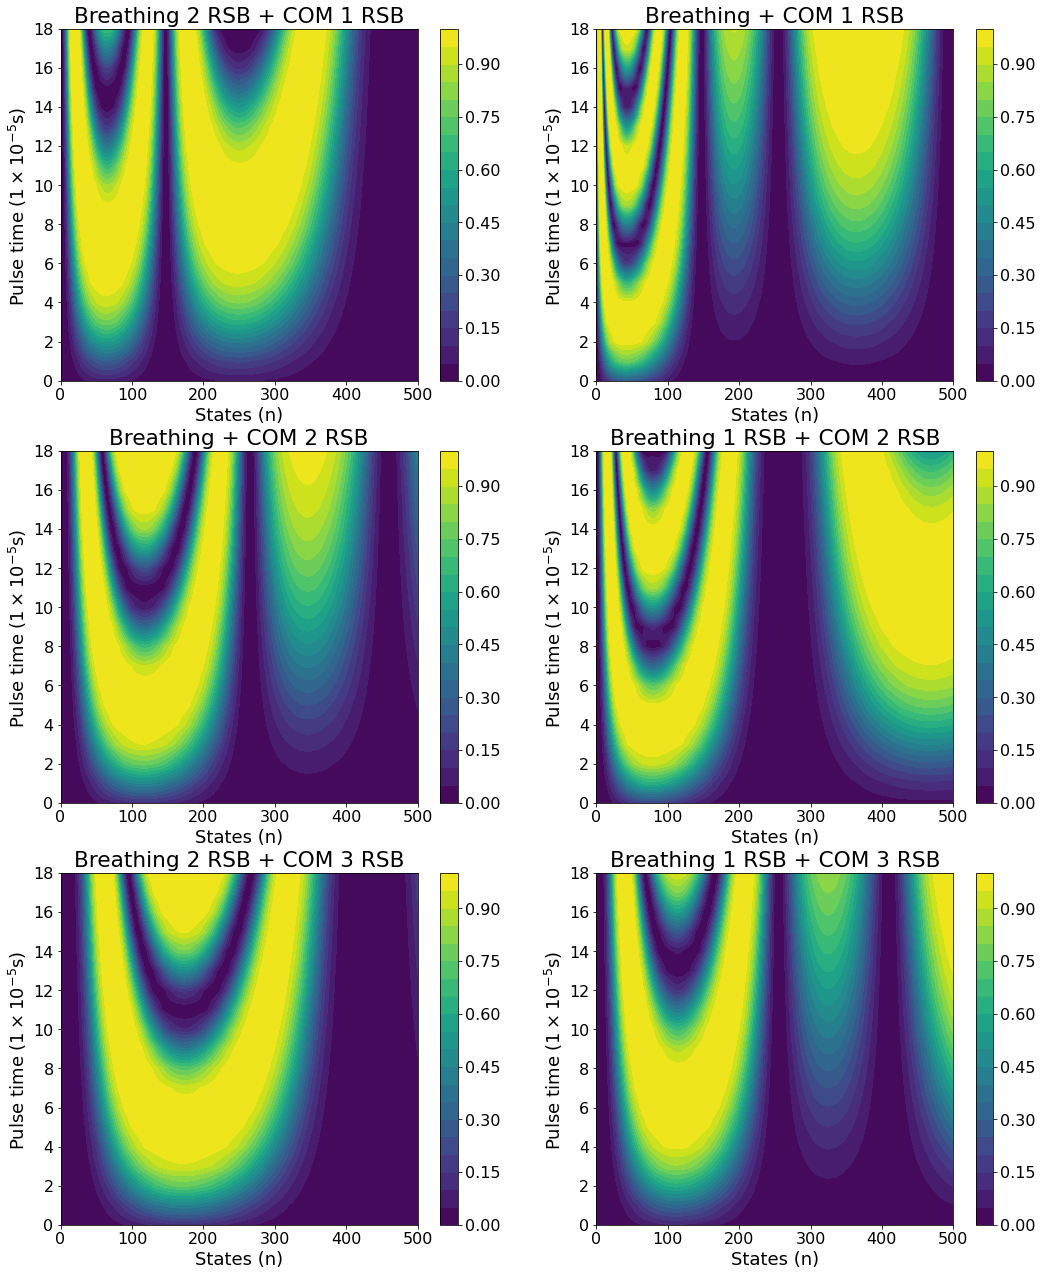

In [28]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8*2, 8.8*2.5] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

pulse_time = np.arange(1, 20, 1)*1e-5
states = np.arange(0, 501, 1)

plt.subplot(3, 2, 2)
twoD_Contour([-1, -1], pulse_time, states)
plt.title('Breathing + COM 1 RSB')

plt.subplot(3, 2, 1)
twoD_Contour([-1, -2], pulse_time, states)
plt.title('Breathing 2 RSB + COM 1 RSB')

plt.subplot(3, 2, 3)
twoD_Contour([-2, -2], pulse_time, states)
plt.title('Breathing + COM 2 RSB')

plt.subplot(3, 2, 4)
twoD_Contour([-2, -1], pulse_time, states)
plt.title('Breathing 1 RSB + COM 2 RSB')

plt.subplot(3, 2, 5)
twoD_Contour([-3, -2], pulse_time, states)
plt.title('Breathing 2 RSB + COM 3 RSB')

plt.subplot(3, 2, 6)
twoD_Contour([-3, -1], pulse_time, states)
plt.title('Breathing 1 RSB + COM 3 RSB')

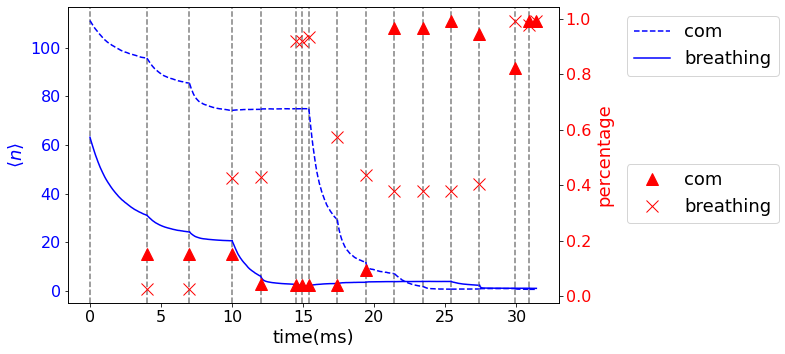

In [4]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

laser1 = pulse(pulse_length = 8e-5, N = 50, sideband = [-1, -2])
laser2 = pulse(pulse_length = 6e-5, N = 50, sideband = [-3, -2])
laser3 = pulse(pulse_length = 6e-5, N = 50, sideband = [-3, -1])
laser4 = pulse(pulse_length = 4e-5, N = 50, sideband = [0, -2])
laser5 = pulse(pulse_length = 5e-5, N = 50, sideband = [0, -1])
laser6 = pulse(pulse_length = 4e-5, N = 10, sideband = [0, -2])
laser7 = pulse(pulse_length = 5e-5, N = 10, sideband = [0, -1])
laser8 = pulse(pulse_length = 2e-5, N = 100, sideband = [-3, 0])
laser9 = pulse(pulse_length = 2e-5, N = 100, sideband = [-2, 0])
laser10 = pulse(pulse_length = 2e-5, N = 100, sideband = [-1, 0])
laser11 = pulse(pulse_length = 2e-5, N = 50, sideband = [-1, 0])

t = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([170, 150]), ore = False, M = 1000, 
            thermal_state = True, neglect_entanglement = False)

lasers = np.array([laser1, laser2, laser3, laser4, laser5, laser6, laser7, 
                   laser8, laser9, laser10, laser8, laser10, laser4, laser5, laser11, laser7])
c, b, c_all, b_all, c_pc, b_pc= plot_cooling(t, lasers)


Text(0.5, 1.0, 'COM')

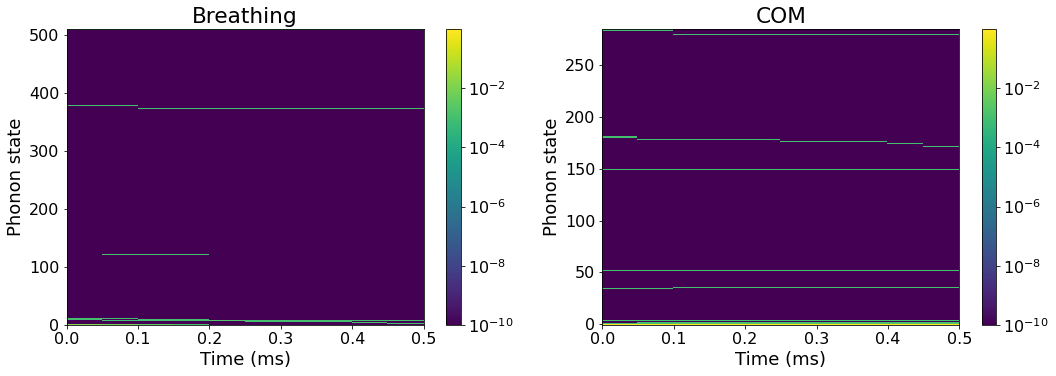

In [5]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [2*8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

plt.subplot(1, 2, 1)
twod_traj_N_ions(pulse = lasers[-1], trap = t, all_data = b_all[-1])
plt.title('Breathing')

plt.subplot(1, 2, 2)
twod_traj_N_ions(pulse = lasers[-1], trap = t, all_data = c_all[-1])
plt.title('COM')

In [6]:
b_pc[-1], c_pc[-1]

([0.979, 0.985, 0.991, 0.993, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994],
 [0.993, 0.992, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991])

Text(0.5, 1.0, 'COM laser 3')

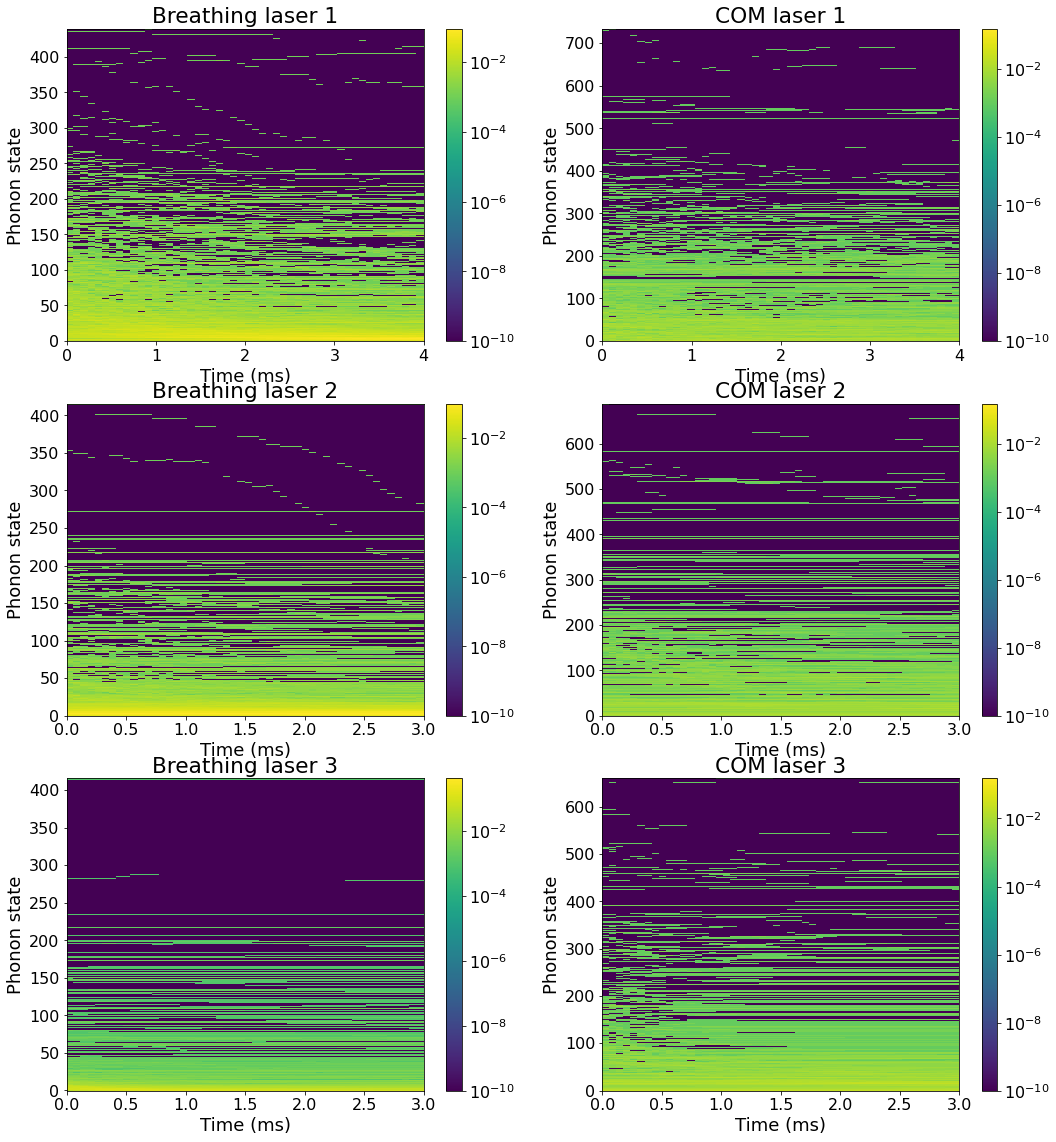

In [127]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8*2, 15*8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

n = 12

plt.subplot(n, 2, 1)
twod_traj_N_ions(pulse = lasers[0], trap = t, all_data = b_all[0])
plt.title('Breathing laser %s'%(1))

plt.subplot(n, 2, 2)
twod_traj_N_ions(pulse = lasers[0], trap = t, all_data = c_all[0])
plt.title('COM laser %s'%(1))

plt.subplot(n, 2, 3)
twod_traj_N_ions(pulse = lasers[1], trap = t, all_data = b_all[1])
plt.title('Breathing laser %s'%(2))

plt.subplot(n, 2, 4)
twod_traj_N_ions(pulse = lasers[1], trap = t, all_data = c_all[1])
plt.title('COM laser %s'%(2))

plt.subplot(n, 2, 5)
twod_traj_N_ions(pulse = lasers[2], trap = t, all_data = b_all[2])
plt.title('Breathing laser %s'%(3))

plt.subplot(n, 2, 6)
twod_traj_N_ions(pulse = lasers[2], trap = t, all_data = c_all[2])
plt.title('COM laser %s'%(3))


Text(0.5, 1.0, 'COM laser 6')

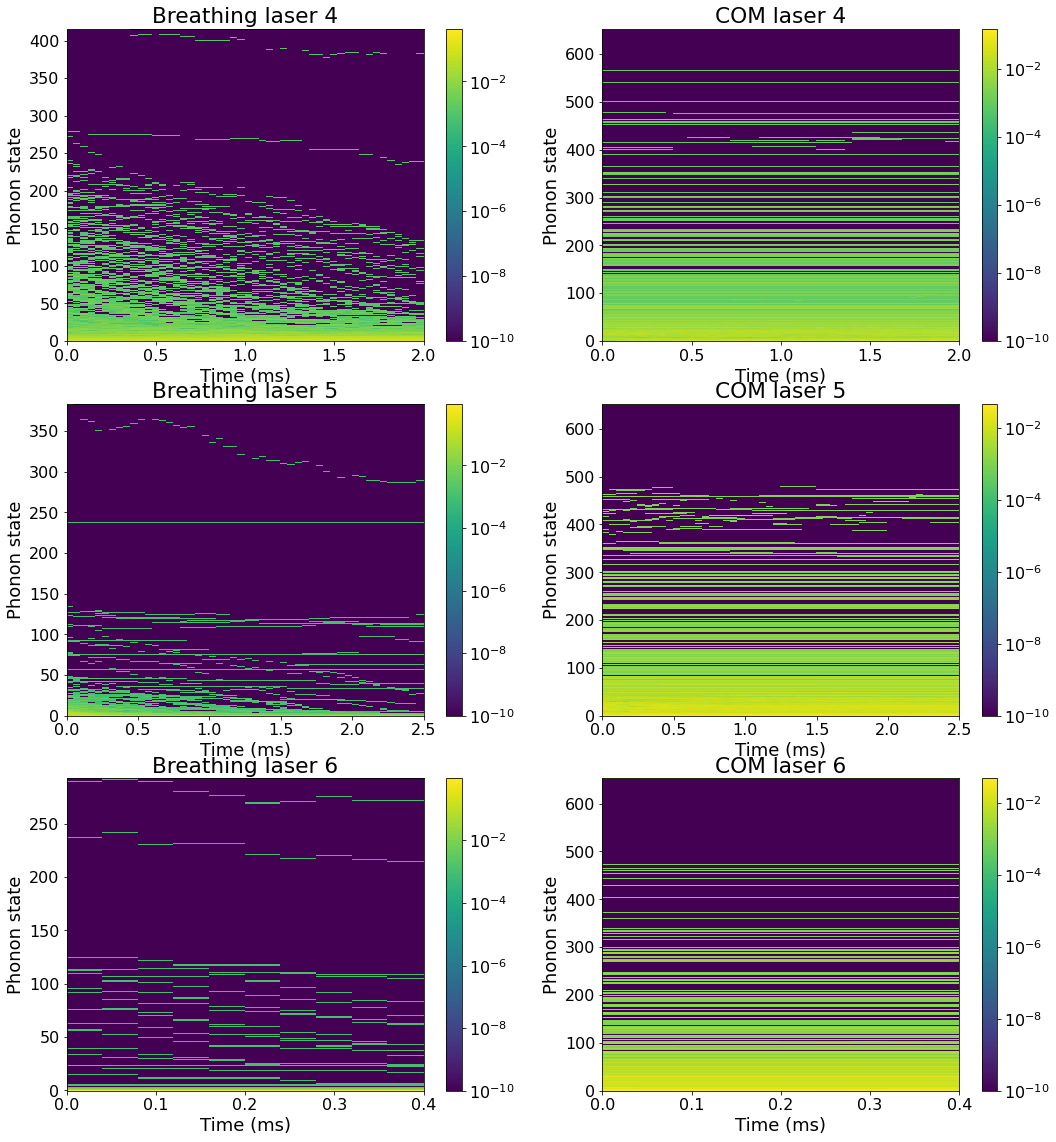

In [128]:
plt.subplot(n, 2, 7)
twod_traj_N_ions(pulse = lasers[3], trap = t, all_data = b_all[3])
plt.title('Breathing laser %s'%(4))

plt.subplot(n, 2, 8)
twod_traj_N_ions(pulse = lasers[3], trap = t, all_data = c_all[3])
plt.title('COM laser %s'%(4))

plt.subplot(n, 2, 9)
twod_traj_N_ions(pulse = lasers[4], trap = t, all_data = b_all[4])
plt.title('Breathing laser %s'%(5))

plt.subplot(n, 2, 10)
twod_traj_N_ions(pulse = lasers[4], trap = t, all_data = c_all[4])
plt.title('COM laser %s'%(5))

plt.subplot(n, 2, 11)
twod_traj_N_ions(pulse = lasers[5], trap = t, all_data = b_all[5])
plt.title('Breathing laser %s'%(6))

plt.subplot(n, 2, 12)
twod_traj_N_ions(pulse = lasers[5], trap = t, all_data = c_all[5])
plt.title('COM laser %s'%(6))


Text(0.5, 1.0, 'COM laser 9')

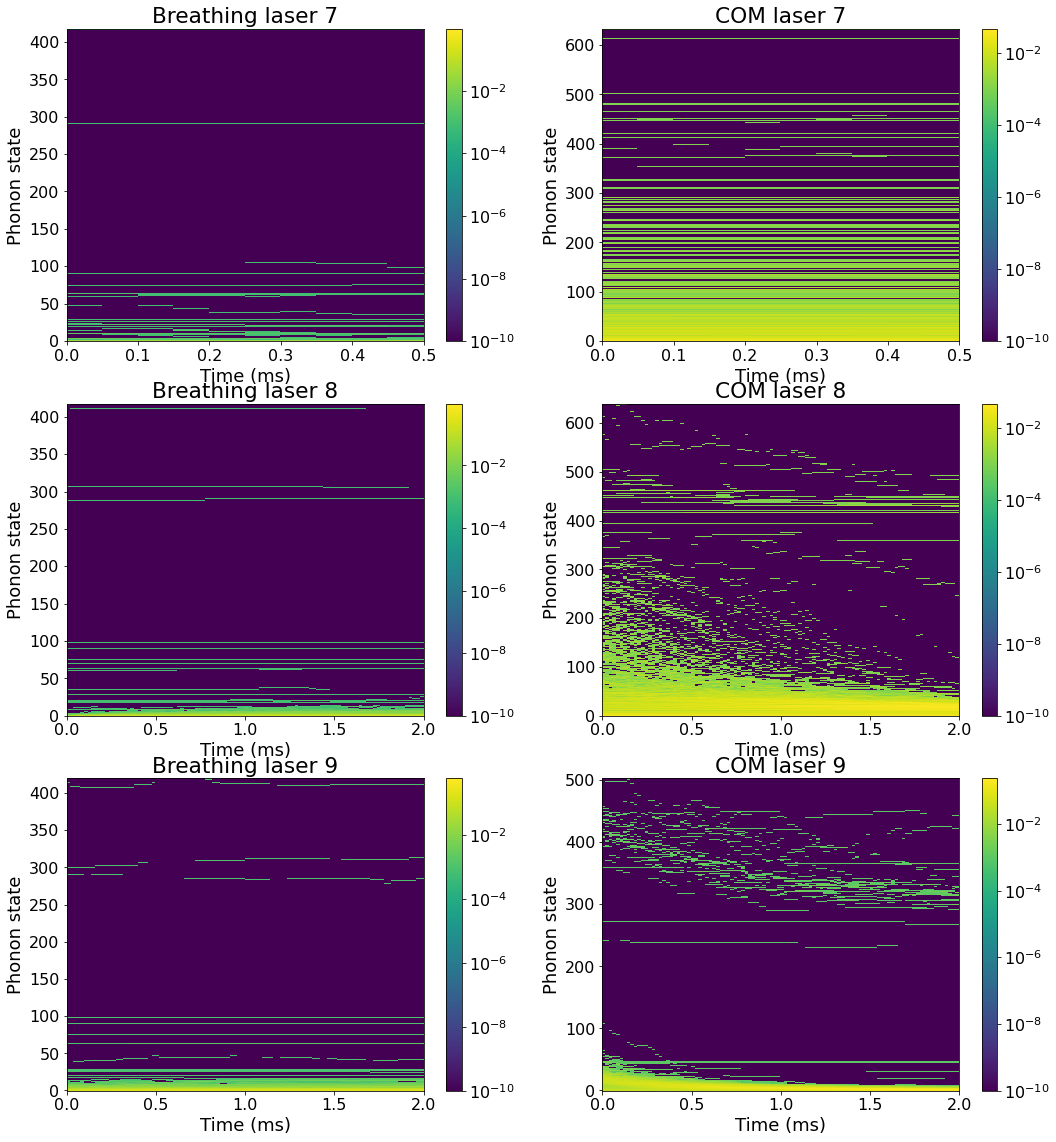

In [119]:
plt.subplot(n, 2, 13)
twod_traj_N_ions(pulse = lasers[6], trap = t, all_data = b_all[6])
plt.title('Breathing laser %s'%(7))

plt.subplot(n, 2, 14)
twod_traj_N_ions(pulse = lasers[6], trap = t, all_data = c_all[6])
plt.title('COM laser %s'%(7))

plt.subplot(n, 2, 15)
twod_traj_N_ions(pulse = lasers[7], trap = t, all_data = b_all[7])
plt.title('Breathing laser %s'%(8))

plt.subplot(n, 2, 16)
twod_traj_N_ions(pulse = lasers[7], trap = t, all_data = c_all[7])
plt.title('COM laser %s'%(8))

plt.subplot(n, 2, 17)
twod_traj_N_ions(pulse = lasers[8], trap = t, all_data = b_all[8])
plt.title('Breathing laser %s'%(9))

plt.subplot(n, 2, 18)
twod_traj_N_ions(pulse = lasers[8], trap = t, all_data = c_all[8])
plt.title('COM laser %s'%(9))

Text(0.5, 1.0, 'COM laser 10')

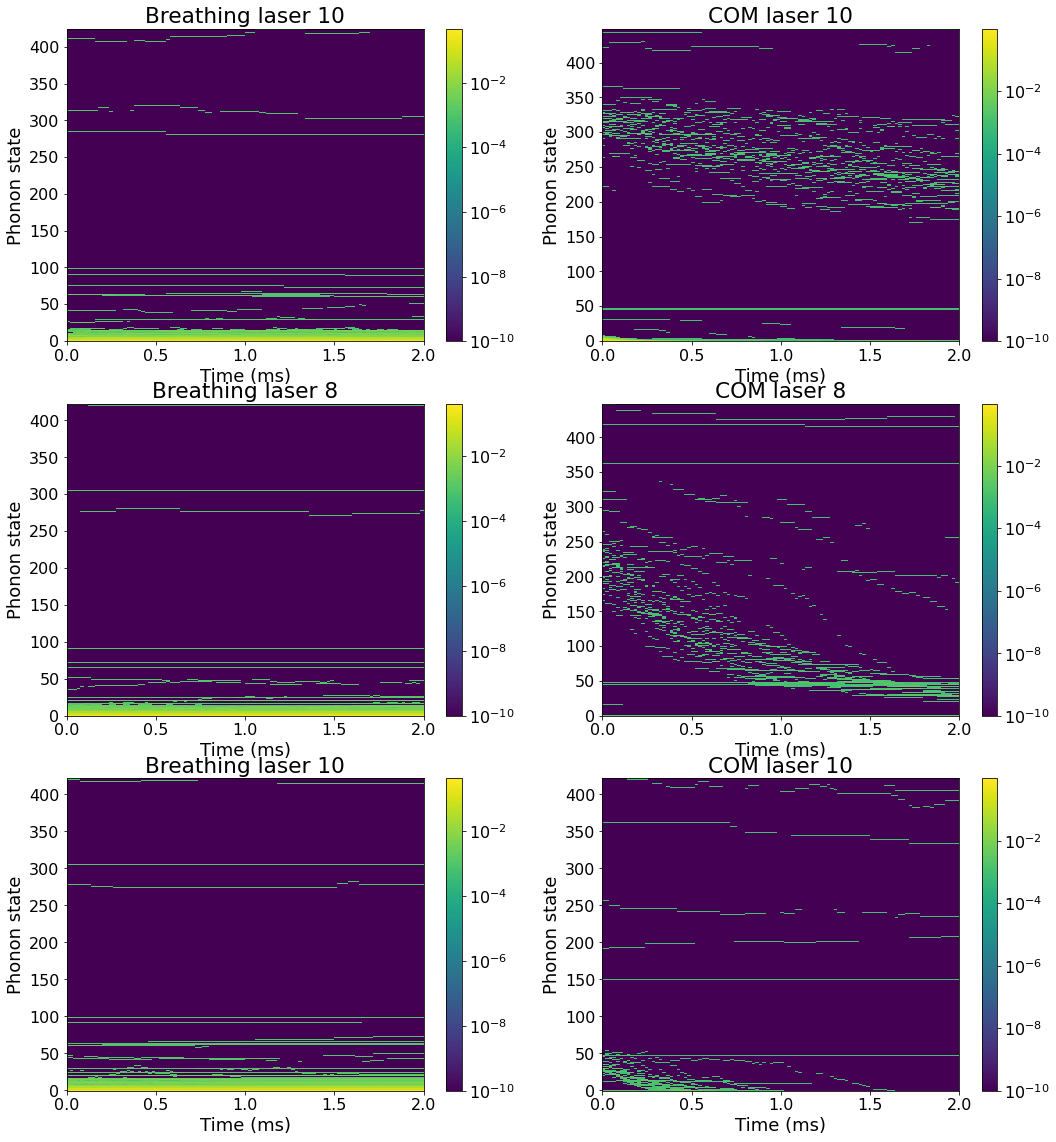

In [120]:
plt.subplot(n, 2, 19)
twod_traj_N_ions(pulse = lasers[9], trap = t, all_data = b_all[9])
plt.title('Breathing laser %s'%(10))

plt.subplot(n, 2, 20)
twod_traj_N_ions(pulse = lasers[9], trap = t, all_data = c_all[9])
plt.title('COM laser %s'%(10))

plt.subplot(n, 2, 21)
twod_traj_N_ions(pulse = lasers[10], trap = t, all_data = b_all[10])
plt.title('Breathing laser %s'%(8))

plt.subplot(n, 2, 22)
twod_traj_N_ions(pulse = lasers[10], trap = t, all_data = c_all[10])
plt.title('COM laser %s'%(8))

plt.subplot(n, 2, 23)
twod_traj_N_ions(pulse = lasers[11], trap = t, all_data = b_all[11])
plt.title('Breathing laser %s'%(10))

plt.subplot(n, 2, 24)
twod_traj_N_ions(pulse = lasers[11], trap = t, all_data = c_all[11])
plt.title('COM laser %s'%(10))

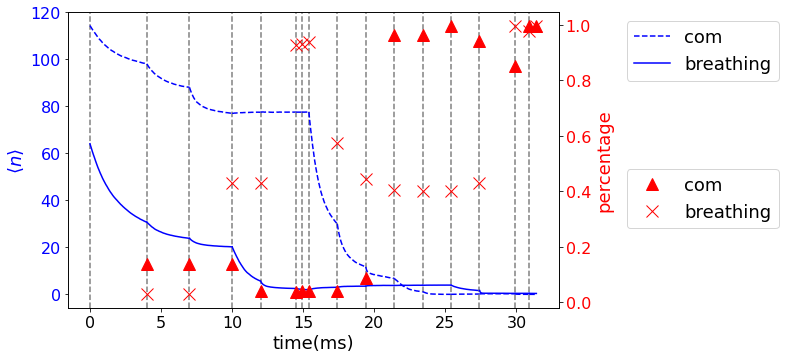

In [98]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

random.seed(10)
laser1 = pulse(pulse_length = 8e-5, N = 50, sideband = np.array([-1, -2]))
laser2 = pulse(pulse_length = 6e-5, N = 50, sideband = [-3, -2])
laser3 = pulse(pulse_length = 6e-5, N = 50, sideband = [-3, -1])
laser4 = pulse(pulse_length = 4e-5, N = 50, sideband = [0, -2])
laser5 = pulse(pulse_length = 5e-5, N = 50, sideband = [0, -1])
laser6 = pulse(pulse_length = 4e-5, N = 10, sideband = [0, -2])
laser7 = pulse(pulse_length = 5e-5, N = 10, sideband = [0, -1])
laser8 = pulse(pulse_length = 2e-5, N = 100, sideband = [-3, 0])
laser9 = pulse(pulse_length = 2e-5, N = 100, sideband = [-2, 0])
laser10 = pulse(pulse_length = 2e-5, N = 100, sideband = [-1, 0])
laser11 = pulse(pulse_length = 2e-5, N = 50, sideband = [-1, 0])

t = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([170, 150]), ore = False, M = 1000, 
            thermal_state = True, neglect_entanglement = True)

lasers = np.array([laser1, laser2, laser3, laser4, laser5, laser6, laser7, 
                   laser8, laser9, laser10, laser8, laser10, laser4, laser5, laser11, laser7])
c, b, c_all, b_all, c_pc, b_pc= plot_cooling(t, lasers)

In [99]:
b_pc[-1], c_pc[-1]

([0.978, 0.986, 0.995, 0.995, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996],
 [0.997, 0.997, 0.996, 0.996, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995])

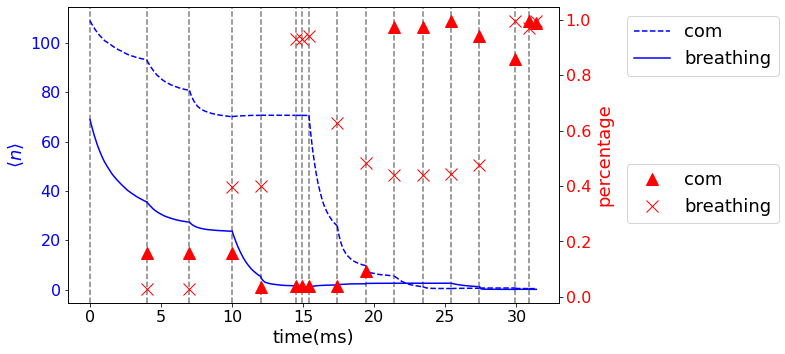

In [20]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

random.seed(10)
laser1 = pulse(pulse_length = 8e-5, N = 50, sideband = np.array([-1, -2]))
laser2 = pulse(pulse_length = 6e-5, N = 50, sideband = [-3, -2])
laser3 = pulse(pulse_length = 6e-5, N = 50, sideband = [-3, -1])
laser4 = pulse(pulse_length = 4e-5, N = 50, sideband = [0, -2])
laser5 = pulse(pulse_length = 5e-5, N = 50, sideband = [0, -1])
laser6 = pulse(pulse_length = 4e-5, N = 10, sideband = [0, -2])
laser7 = pulse(pulse_length = 5e-5, N = 10, sideband = [0, -1])
laser8 = pulse(pulse_length = 2e-5, N = 100, sideband = [-3, 0])
laser9 = pulse(pulse_length = 2e-5, N = 100, sideband = [-2, 0])
laser10 = pulse(pulse_length = 2e-5, N = 100, sideband = [-1, 0])
laser11 = pulse(pulse_length = 2e-5, N = 50, sideband = [-1, 0])

t = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([170, 150]), ore = False, M = 1000, 
            thermal_state = True, neglect_entanglement = False)

lasers = np.array([laser1, laser2, laser3, laser4, laser5, laser6, laser7, 
                   laser8, laser9, laser10, laser8, laser10, laser4, laser5, laser11, laser7])
c, b, c_all, b_all, c_pc, b_pc= plot_cooling(t, lasers)

In [21]:
b_pc[-1], c_pc[-1]

([0.973, 0.991, 0.996, 0.996, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997, 0.997],
 [0.996, 0.993, 0.992, 0.992, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991])

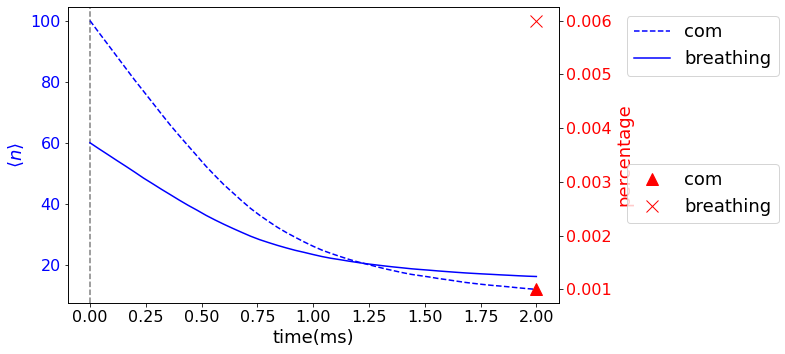

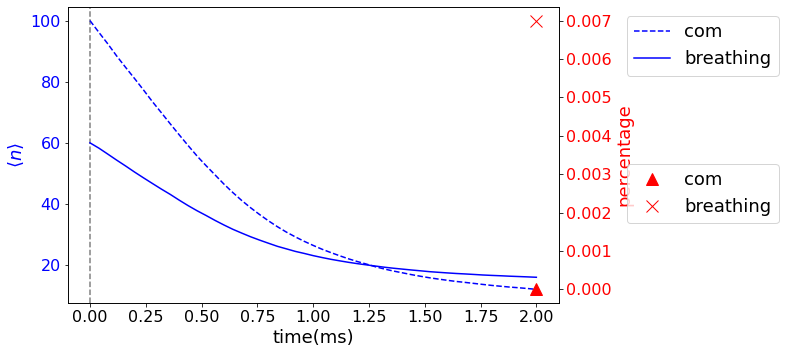

In [111]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

random.seed(10)
laser = pulse(pulse_length = 4e-5, N = 50, sideband = [-2, -1])
lasers = np.array([laser])
t_entag = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([100, 60]), ore = False, M = 1000, 
            thermal_state = False, neglect_entanglement = False)
t_no_entag = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([100, 60]), ore = False, M = 1000, 
            thermal_state = False, neglect_entanglement = True)
c_ent, b_ent, c_all_ent, b_all_ent, c_pc_ent, b_pc_ent= plot_cooling(t_entag, lasers)
c, b, c_all, b_all, c_pc, b_pc= plot_cooling(t_no_entag, lasers)

In [114]:
c_pc_ent[-1][-1], b_pc_ent[-1][-1]

(0.001, 0.006)

In [115]:
c_pc[-1][-1], b_pc[-1][-1]

(0.0, 0.007)

Text(0.5, 1.0, 'COM (no entanglement)')

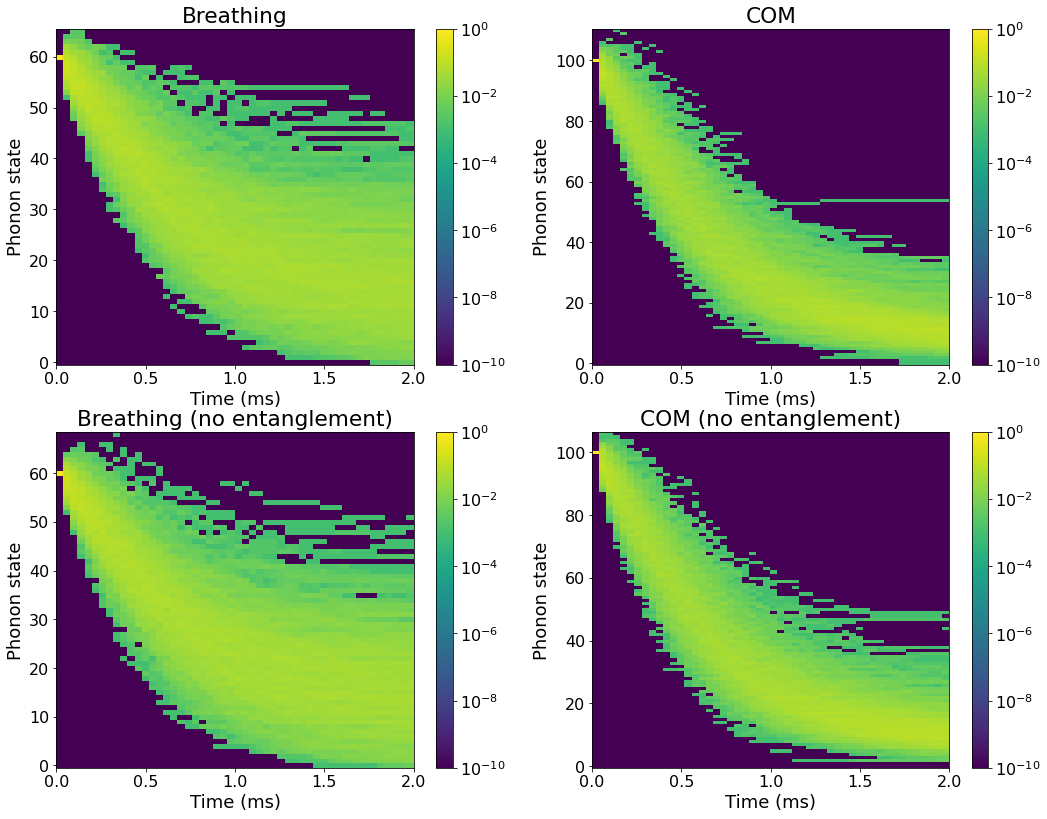

In [116]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [2*8.8, 2.5*8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

plt.subplot(2, 2, 1)
twod_traj_N_ions(pulse = laser, trap = t_entag, all_data = b_all_ent[0])
plt.title('Breathing')

plt.subplot(2, 2, 2)
twod_traj_N_ions(pulse = laser, trap = t_entag, all_data = c_all_ent[0])
plt.title('COM')

plt.subplot(2, 2, 3)
twod_traj_N_ions(pulse = laser, trap = t_no_entag, all_data = b_all[0])
plt.title('Breathing (no entanglement)')

plt.subplot(2, 2, 4)
twod_traj_N_ions(pulse = laser, trap = t_entag, all_data = c_all[0])
plt.title('COM (no entanglement)')

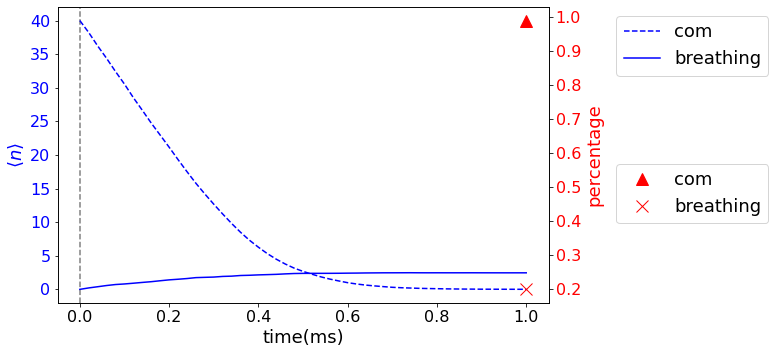

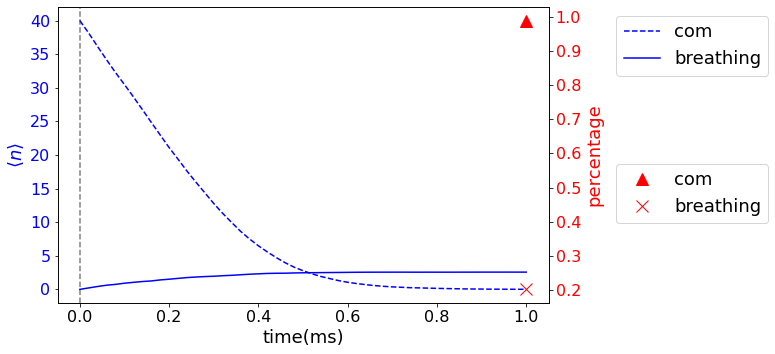

In [120]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

random.seed(10)
laser = pulse(pulse_length = 2e-5, N = 50, sideband = [-1, -0])
lasers = np.array([laser])
t_entag = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([40, 0]), ore = False, M = 1000, 
            thermal_state = False, neglect_entanglement = False)
t_no_entag = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([40, 0]), ore = False, M = 1000, 
            thermal_state = False, neglect_entanglement = True)
c_ent, b_ent, c_all_ent, b_all_ent, c_pc_ent, b_pc_ent= plot_cooling(t_entag, lasers)
c, b, c_all, b_all, c_pc, b_pc= plot_cooling(t_no_entag, lasers)

In [121]:
c_pc_ent[-1][-1], b_pc_ent[-1][-1]

(0.99, 0.199)

In [122]:
c_pc[-1][-1], b_pc[-1][-1]

(0.989, 0.202)

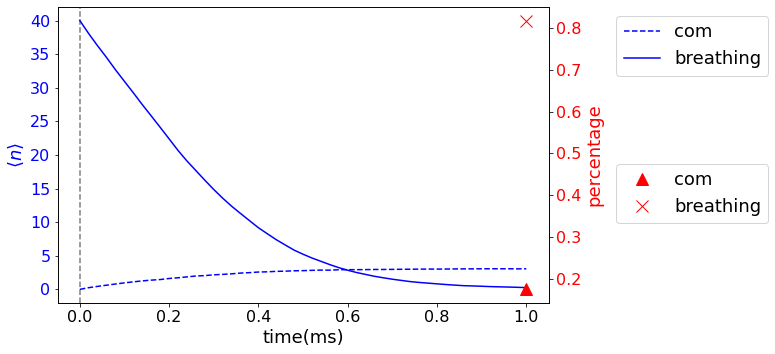

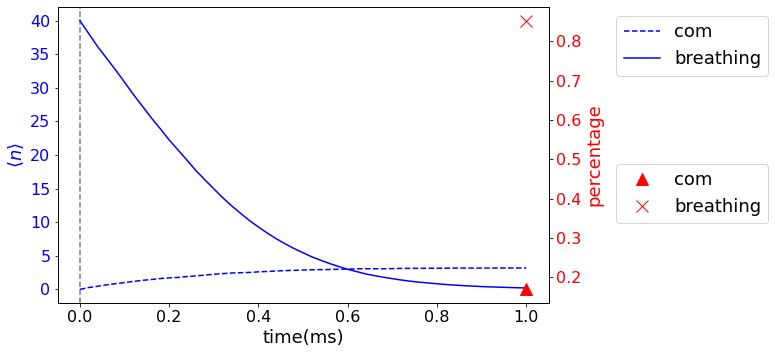

In [123]:
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'font.family': 'sans-serif', # Optionally change the font family to sans-serif
   'font.serif': 'Arial', # Optionally change the font to Arial
   'legend.fontsize': 18,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16, 
   'figure.figsize': [8.8, 8.8/1.618] # Using the golden ratio and standard column width of a journal
} 
plt.rcParams.update(params)

random.seed(10)
laser = pulse(pulse_length = 2e-5, N = 50, sideband = [0, -1])
lasers = np.array([laser])
t_entag = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([0, 40]), ore = False, M = 1000, 
            thermal_state = False, neglect_entanglement = False)
t_no_entag = iontrap(G = 2, T0 = 0.001, w = wz, no_decay = False, n0 = np.array([0, 40]), ore = False, M = 1000, 
            thermal_state = False, neglect_entanglement = True)
c_ent, b_ent, c_all_ent, b_all_ent, c_pc_ent, b_pc_ent= plot_cooling(t_entag, lasers)
c, b, c_all, b_all, c_pc, b_pc= plot_cooling(t_no_entag, lasers)

In [124]:
c_pc_ent[-1][-1], b_pc_ent[-1][-1]

(0.174, 0.818)

In [125]:
c_pc[-1][-1], b_pc[-1][-1]

(0.169, 0.853)

## Cooling more than two ions <a id="more"></a>

### 3 ions planar crystal<a id="3ions"></a>

<div style="background-color: #FFF8C6">
Motion of ions in 2D plane, the third plot represents the COM mode, and the first two plots represent tilt modes degenerate in frequency.

Normal frequencies: (in unit of we)
tilt 1 = 5.421726568676707, tilt 2 = 5.421726958715784, COM = 5.513178464199704
Normal coordinates: (row --> ions, coloumn --> modes)
[[-5.25914717e-10 -8.16496581e-01 -5.77350269e-01]
 [-7.07106781e-01  4.08248291e-01 -5.77350269e-01]
 [ 7.07106781e-01  4.08248290e-01 -5.77350269e-01]]


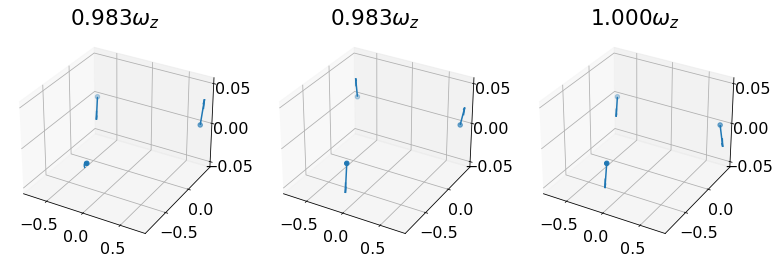

In [19]:
params = {'figure.figsize': [8.8*1.5, 8.8/1.618]} 
plt.rcParams.update(params)

plot_nm_axial_direction(N = 3)
normal_modes = icc_normal_modes_z(N = 3)
print('Normal frequencies: (in unit of we)')
print('tilt 1 = %s, tilt 2 = %s, COM = %s'%(normal_modes[0][0], normal_modes[0][1], normal_modes[0][2]))
print('Normal coordinates: (row --> ions, coloumn --> modes)')
print(normal_modes[1])

<div style="background-color: #FFF8C6">
Although the two tilt modes are degenerate in frequency, but ions under these two modes have different motions, and therefore different normal coordinates, this leads to different Lamb-Dicke parameters for different ions in different modes. 

In [20]:
print('Lamb-Dicke parameters: (row --> ions, coloumn --> modes)')
print(LambDicke_planar(N = 3))

Lamb-Dicke parameters: (row --> ions, coloumn --> modes)
[[7.23718265e-11 1.12359181e-01 7.87882332e-02]
 [9.73059084e-02 5.61795905e-02 7.87882332e-02]
 [9.73059084e-02 5.61795903e-02 7.87882332e-02]]


In [9]:
t3_ion = iontrap(G = 3, T0 = 0.001, n0 = np.array([50, 50, 50]), M = 10000, ore = True, thermal_state = True, 
              neglect_entanglement = True, basis = False)
print('Averaged initial phonon states from 10000 realisations:')
print('tilt 1 = %s, tilt 2 = %s, COM = %s'%(np.average(t3_ion.n[0]), np.average(t3_ion.n[1]), np.average(t3_ion.n[2])))

Averaged initial phonon states from 10000 realisations:
tilt 1 = 41.5551, tilt 2 = 41.8407, COM = 41.2418


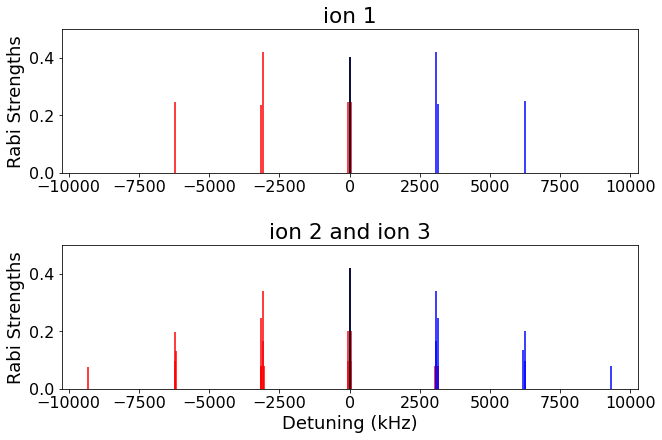

In [4]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
sb, detune, stren = sideband_strength(N = 3, current_mode = np.array([[42], [42], [41]]), sb = 1, xmin = -2500, 
                                      xmax = 2500, ion_n = 0)

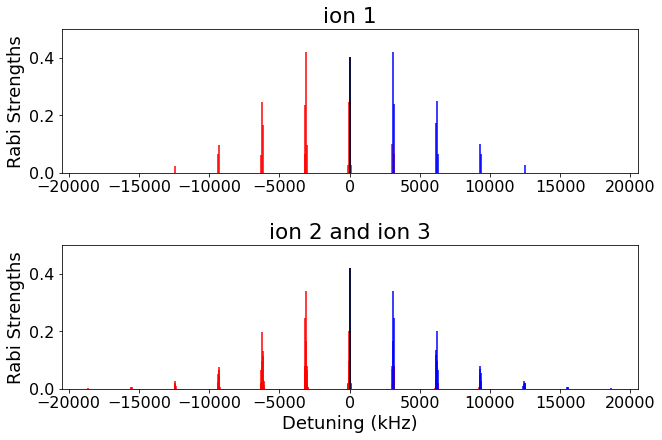

In [50]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
sb, detune, stren = sideband_strength(N = 3, current_mode = np.array([[42], [42], [41]]), sb = 2, xmin = -5000, 
                                      xmax = -2000, ion_n = 0)

In [53]:
print('sidebands which have rabi strength greater than 0.06:')
for stren_i in stren:
    if stren_i > 0.06:
        print('sideband is %s, rabi strength is %s'%(sb[stren.index(stren_i)], stren_i))

sidebands which have rabi strength greater than 0.06:
sideband is [-2, 0, 1], rabi strength is 0.06687595106666887
sideband is [-1, -1, 1], rabi strength is 0.0780950159603053
sideband is [-1, 0, 0], rabi strength is 0.3388229363096632
sideband is [-1, 1, -1], rabi strength is 0.07820037195280763
sideband is [0, -1, 0], rabi strength is 0.16433378360241835
sideband is [0, 0, -1], rabi strength is 0.24530213236917933
sideband is [1, -1, -1], rabi strength is 0.07792925777682763


In [40]:
0.06*rb

15079.644737231007

In [36]:
rabi_freq = 0.05*rb
detune = 5.45*we
print('oscillation amplitude = %s'%(rabi_freq**2/(rabi_freq**2 + detune**2)))

oscillation amplitude = 1.6372838177774696e-05


Text(0, 0.5, 'Rabi oscillation')

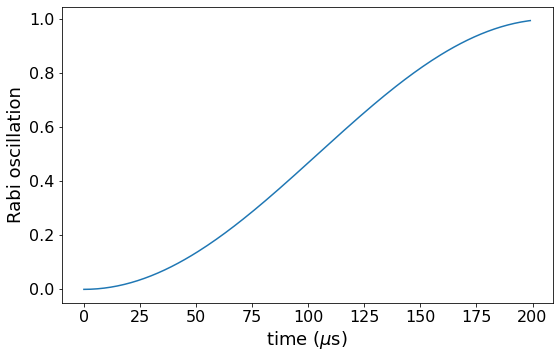

In [39]:
t = np.arange(0, 200, 1)*1e-6
#detune = 5.45*we
detune = 0
rabi_oscillation = (np.sin(t*np.sqrt((rb*0.06)**2 + (detune)**2)/2))**2
plt.plot(rabi_oscillation)
plt.xlabel('time ($\mu$s)')
plt.ylabel('Rabi oscillation')

<div style="background-color: #FFF8C6">
Rabi oscillation is $\sin ^{2}\left(\frac{\sqrt{\Omega_{n, k, n^{\prime}, k^{\prime}}^{2}+\Delta^{2}}}{2} t\right) $, when there's no detuning, a small rabi frequency leads to longer rabi oscillation period, implying that we need a longer laser pulse duration to reach maximum oscillation amplitude. When Rabi frequency is $0.06\Omega_{0} = 15079.645$, the first maximum amplitude occurs at pulse length = 200$\mu s$. Almost only the first order sideband of each mode corresponds to a Rabi strength greater than 0.06 as shown above. If the laser only addresses sideband of one mode each time, there will be detuning of one order of the motional frequency, this detuning reduce the oscillation amplitude by a factor of about $10^{-5}$.

([[-1, -1, 1], [-1, 1, -1], [1, -1, -1]],
 [0.023588742023197246, 1.0, 1.0],
 [[-1, 0, 0], [0, -1, 0], [0, 0, -1]],
 [0.4859026841300778, 0.5246813034560067, 1.0])

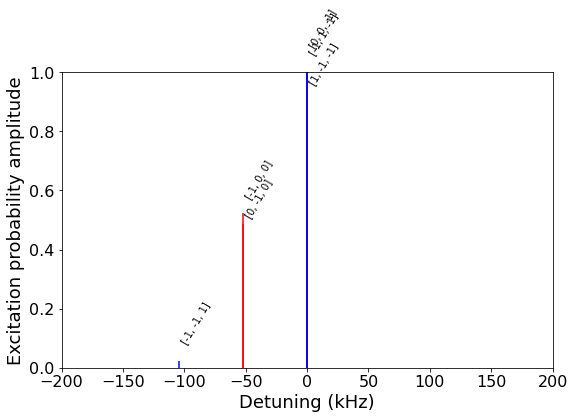

In [45]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
prob_amp(N = np.array([43, 43, 41]), target_sideband = np.array([0, 0, -1]), sb = 1)

([[-1, -1, 1], [-1, 1, -1], [1, -1, -1]],
 [0.08530038825425242, 0.08546071259469405, 0.08494329793672444],
 [[-1, 0, 0], [0, -1, 0], [0, 0, -1]],
 [1.0, 1.0, 0.5685158076488992])

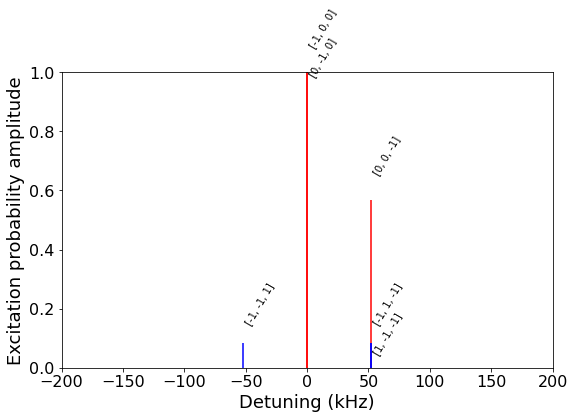

In [46]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
prob_amp(N = np.array([43, 43, 41]), target_sideband = np.array([0, -1, 0]), sb = 1) 
# target sidebands [0, -1, 0] and [-1, 0, 0] give the same results 

<div style="background-color: #FFF8C6">
From the above, we can see that laser only addresses first order sideband of one mode each time is sufficient. 

**On resonant laser dressing**

Excitation probability of sideband [0, 0, -1] for 3 ions when laser addresses resonantly 


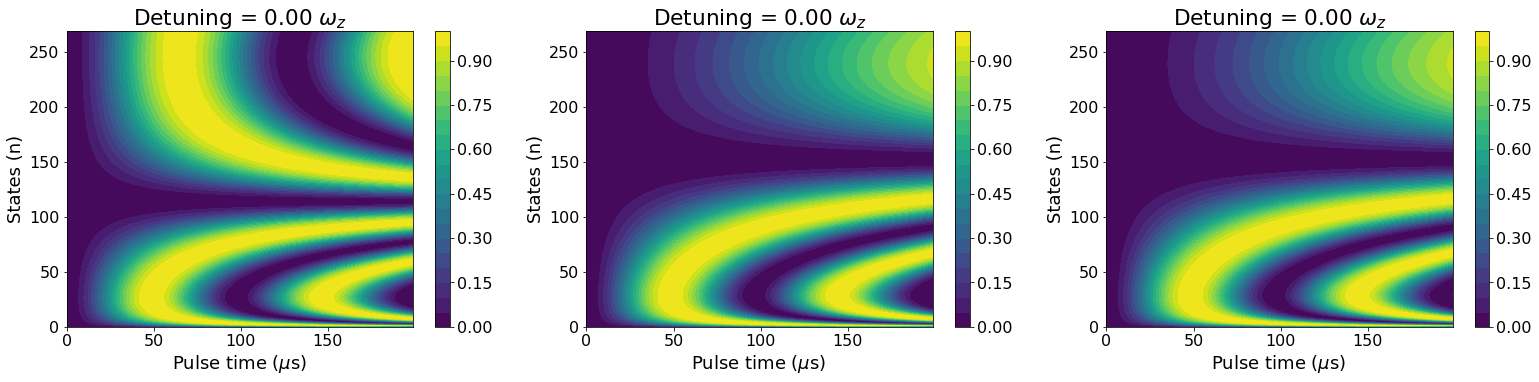

In [55]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Excitation probability of sideband [0, 0, -1] for 3 ions when laser addresses resonantly ')
plt.subplot(1, 3, 1)
twoD_Contour_3(sideband = np.array([0, 0, -1]), target_sideband = np.array([0, 0, -1]), ion = 0)
plt.subplot(1, 3, 2)
twoD_Contour_3(sideband = np.array([0, 0, -1]), target_sideband = np.array([0, 0, -1]), ion = 1)
plt.subplot(1, 3, 3)
twoD_Contour_3(sideband = np.array([0, 0, -1]), target_sideband = np.array([0, 0, -1]), ion = 2)

Excitation probability of sideband [0, -1, 0] for 3 ions when laser addresses resonantly 


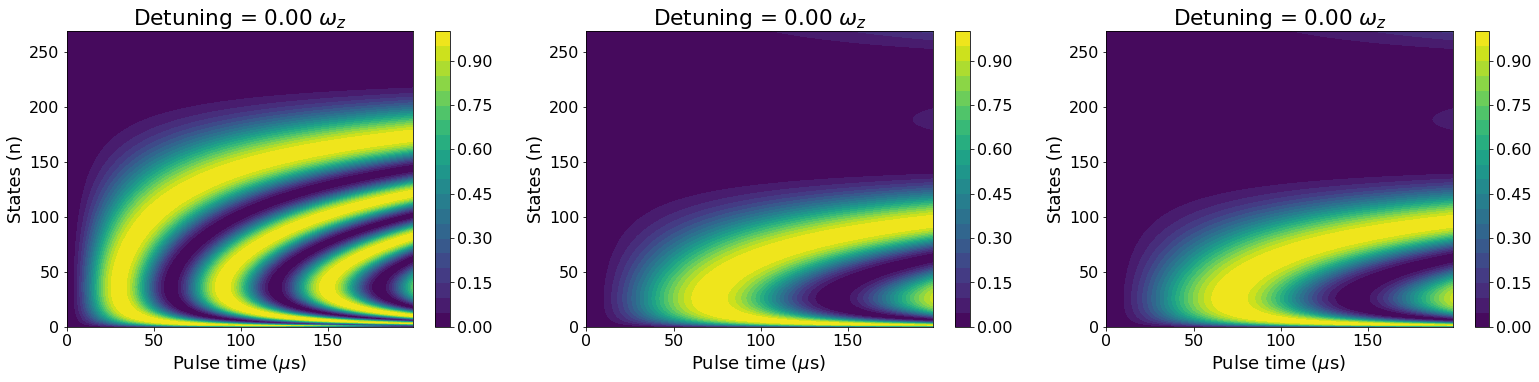

In [56]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Excitation probability of sideband [0, -1, 0] for 3 ions when laser addresses resonantly ')
plt.subplot(1, 3, 1)
twoD_Contour_3(sideband = np.array([0, -1, 0]), target_sideband = np.array([0, -1, 0]), ion = 0)
plt.subplot(1, 3, 2)
twoD_Contour_3(sideband = np.array([0, -1, 0]), target_sideband = np.array([0, -1, 0]), ion = 1)
plt.subplot(1, 3, 3)
twoD_Contour_3(sideband = np.array([0, -1, 0]), target_sideband = np.array([0, -1, 0]), ion = 2)

Excitation probability of sideband [-1, 0, 0] for 3 ions when laser addresses resonantly 


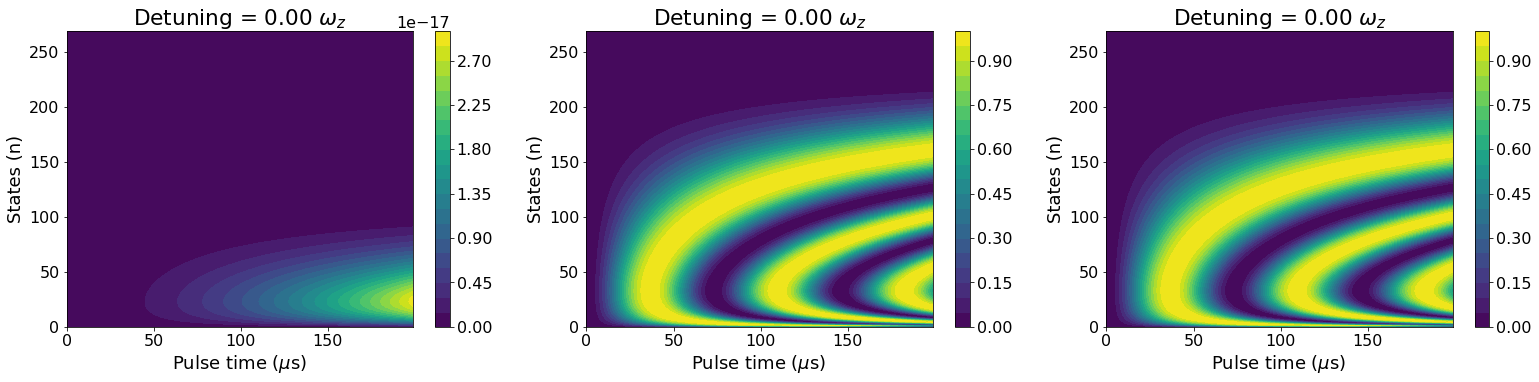

In [57]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Excitation probability of sideband [-1, 0, 0] for 3 ions when laser addresses resonantly ')
plt.subplot(1, 3, 1)
twoD_Contour_3(sideband = np.array([-1, 0, 0]), target_sideband = np.array([-1, 0, 0]), ion = 0)
plt.subplot(1, 3, 2)
twoD_Contour_3(sideband = np.array([-1, 0, 0]), target_sideband = np.array([-1, 0, 0]), ion = 1)
plt.subplot(1, 3, 3)
twoD_Contour_3(sideband = np.array([-1, 0, 0]), target_sideband = np.array([-1, 0, 0]), ion = 2)

<div style="background-color: #FFF8C6">
Since the Lamb-Dicke parameters of ion 2 and ion 3 are the same in three modes, so their plots also look the same. The total effective Rabi strengthof each ion is the product of the normalised rabi strength of the three modes (multiply horizontally in the lamb-dicke matrix).

**Off-resonant laser dressing**

Excitation probability of 1RSB of three modes when laser addresses 1RSB of COM mode, averaged from 3 ions


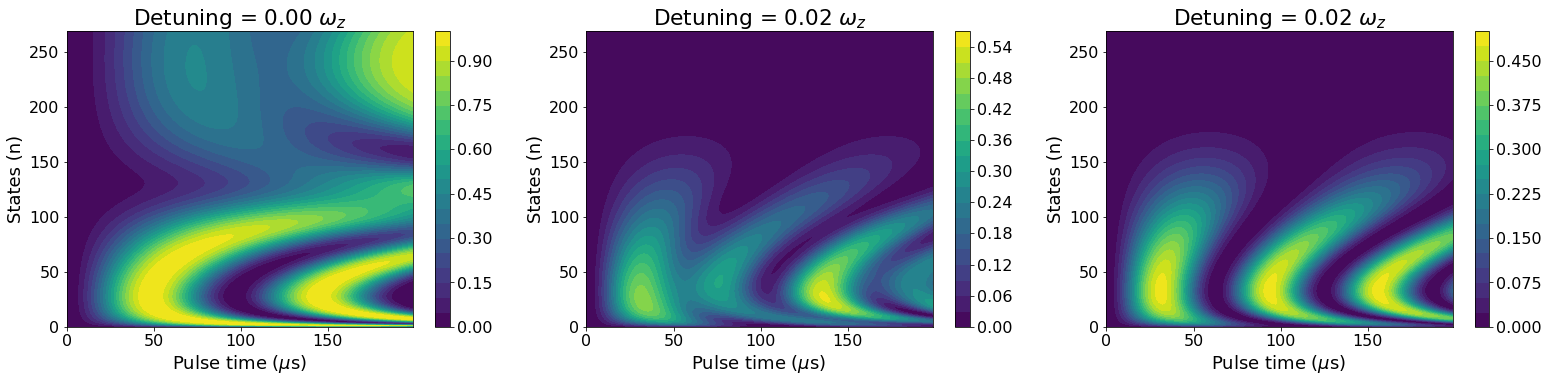

In [59]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Excitation probability of 1RSB of three modes when laser addresses 1RSB of COM mode, averaged from 3 ions')
plt.subplot(1, 3, 1)
twoD_Contour_3(sideband = np.array([0, 0, -1]), target_sideband = np.array([0, 0, -1]), ion = 3)
plt.subplot(1, 3, 2)
twoD_Contour_3(sideband = np.array([0, -1, 0]), target_sideband = np.array([0, 0, -1]), ion = 3)
plt.subplot(1, 3, 3)
twoD_Contour_3(sideband = np.array([-1, 0, 0]), target_sideband = np.array([0, 0, -1]), ion = 3)

Excitation probability of 1RSB of three modes when laser addresses 1RSB of tilt 1 or tilt 2 mode, averaged from 3 ions


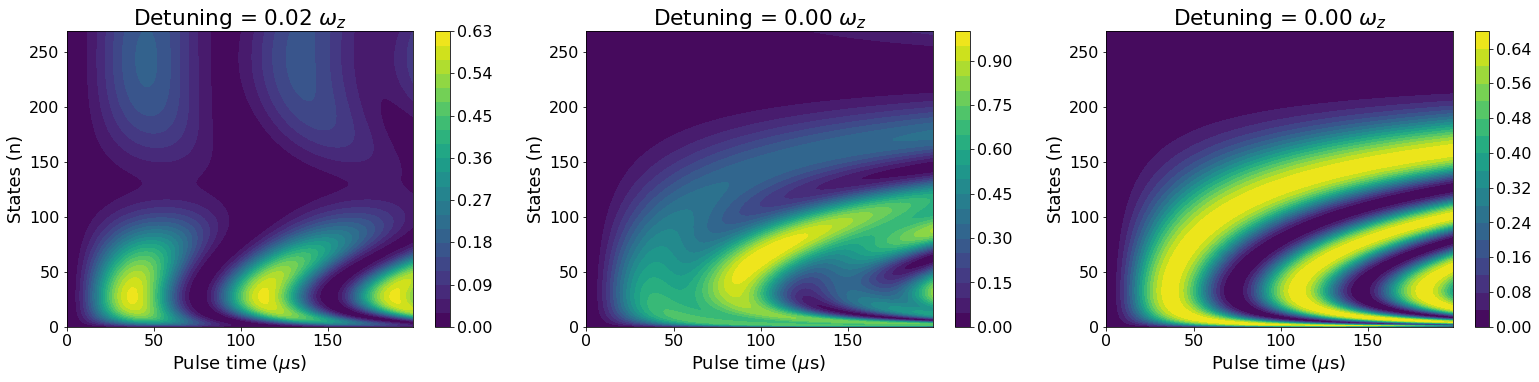

In [62]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Excitation probability of 1RSB of three modes when laser addresses 1RSB of tilt 1 or tilt 2 mode, averaged from 3 ions')
plt.subplot(1, 3, 1)
twoD_Contour_3(sideband = np.array([0, 0, -1]), target_sideband = np.array([0, -1, 0]), ion = 3)
plt.subplot(1, 3, 2)
twoD_Contour_3(sideband = np.array([0, -1, 0]), target_sideband = np.array([0, -1, 0]), ion = 3)
plt.subplot(1, 3, 3)
twoD_Contour_3(sideband = np.array([-1, 0, 0]), target_sideband = np.array([0, -1, 0]), ion = 3)

<div style="background-color: #FFF8C6">
It is also important to decide carefully the time step of pulse durations. If the Rabi oscillation is fast but time step is relatively large, some infomation might be loosing. 

Maximum Rabi frequencies for three ions in phonon range [0, 250]:
[52556.09431206829, 22235.090567588024, 22235.090512553106]


C:\Users\Corde\Documents\MSci Project\Simulations\MSci-Project-\Schrodinger.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  position = np.array([[0, 0.62996, 0, -0.62996],


Text(0, 0.5, '$Sin^{2}(\\omega t)$')

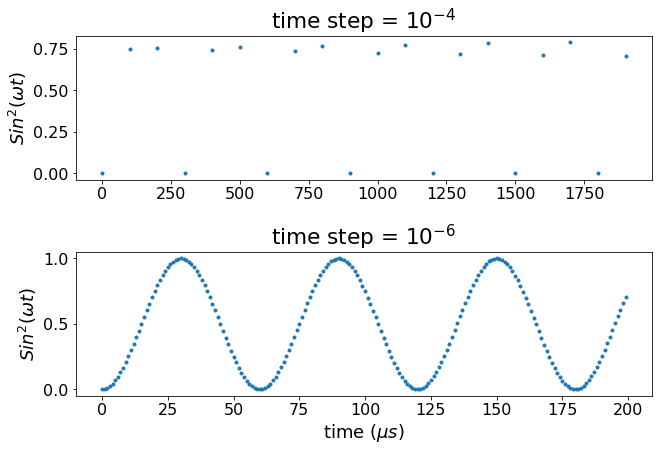

In [89]:
sideband = np.array([0, -1, 0])
target_sideband = np.array([0, -1, 0])

state = np.arange(0, 250)
modes_w, K, m =  icc_normal_modes_z(3)
frequencies = [round(i, -1) for i in modes_w * we]
detuning = sum(target_sideband * frequencies - sideband * frequencies)

R = LoadAnything('3_ions_planar.data')
current_mode = np.array([state for _ in range(3)])
exci = np.array([[0, 1, 2] for _ in range(len(state))]).T
total_sb_stren = rb
for motion_state, mode, sb in zip(current_mode, range(3), sideband):
    sb_stren_this_mode = R[exci, mode, motion_state, motion_state + sb]
    total_sb_stren *= sb_stren_this_mode
modes_w, K, m =  icc_normal_modes_z(4)
detuning = sum(target_sideband * frequencies - sideband * frequencies)
print('Maximum Rabi frequencies for three ions in phonon range [0, 250]:')
print([max([frequency(total_sb_stren[ion][state], detuning) for state in range(len(total_sb_stren[ion]))]) for ion in range(len(total_sb_stren))])

params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)

fig = plt.figure(figsize=(8, 8/1.6))
ax2 = fig.add_axes([0, 0, 1, 0.4])
ax1 = fig.add_axes([0, 0.6, 1, 0.4])

t1 = np.arange(0, 20, 1)*1e-4
ax1.plot(t1*1e6, (np.sin(52386.6*t1))**2, '.')
ax1.set_title(r'time step = $10^{-4}$')
ax1.set_ylabel('$Sin^{2}(\omega t)$')

t2 = np.arange(0, 200, 1)*1e-6
ax2.plot(t2*1e6, (np.sin(52386.6*t2))**2, '.')
ax2.set_title(r'time step = $10^{-6}$')
ax2.set_xlabel('time ($\mu s$)')
ax2.set_ylabel('$Sin^{2}(\omega t)$')

<div style="background-color: #FFF8C6">
By choosing the laser pulse length, we can address the two degenerate modes separately:

In [ ]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)

laser22 = Pulse(pulse_length = 80e-6, N = 100, wavelength = 5.42172696*we)
laser33 = Pulse(pulse_length = 30e-6, N = 400, wavelength = 5.51317846*we)
t32 = iontrap(G = 3, T0 = 0.001, n0 = np.array([50, 50, 50]), M = 10000, ore = True, thermal_state = True, 
              neglect_entanglement = True, basis = False)
lasers2 = np.array([laser22, laser33])
c2, b2, d2, c_all2, b_all2, d_all2, c_pc2, b_pc2, d_pc2= plot_cooling_3_planar(t32, lasers2)

<div style="background-color: #FFF8C6">
But it is also possible to cool the three motional modes together in the three-ion-planar case:

C:\Users\Corde\Documents\MSci Project\Simulations\MSci-Project-\Schrodinger.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  position = np.array([[0, 0.62996, 0, -0.62996],


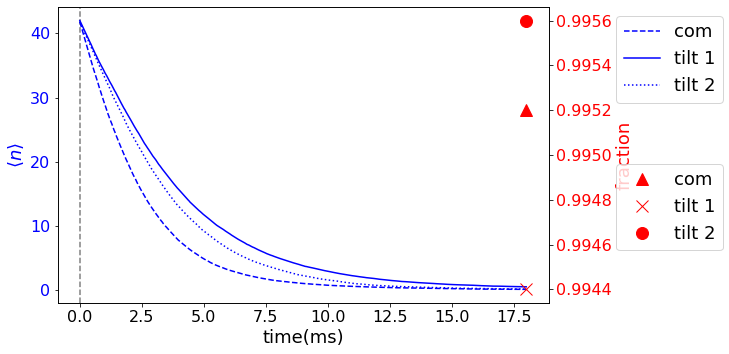

In [227]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)

laser33 = Pulse(pulse_length = 30e-6, N = 600, wavelength = 5.51317846*we)
t33 = iontrap(G = 3, T0 = 0.001, n0 = np.array([50, 50, 50]), M = 5000, ore = True, thermal_state = True, 
              neglect_entanglement = True, basis = False)
lasers3 = np.array([laser33])
c3, b3, d3, c_all3, b_all3, d_all3, c_pc3, b_pc3, d_pc3= plot_cooling_3_planar(t33, lasers3)

### 4 ions planar crystal<a id="4ions"></a>

Normal frequencies: (in unit of we)
tilt 0 = 5.377502379753368, tilt 1 = 5.421727417901244, tilt 2 = 5.421727417901244, COM = 5.513178464199704
Normal coordinates: (row --> ions, coloumn --> modes)
[[ 5.00000000e-01  7.07106781e-01  0.00000000e+00 -5.00000000e-01]
 [-5.00000000e-01  4.15607935e-15 -7.07106781e-01 -5.00000000e-01]
 [ 5.00000000e-01 -7.07106781e-01 -7.71581605e-15 -5.00000000e-01]
 [-5.00000000e-01 -3.56011138e-15  7.07106781e-01 -5.00000000e-01]]


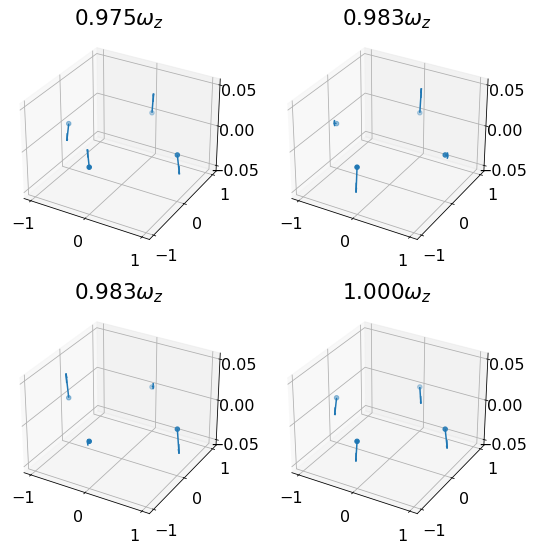

In [96]:
params = {'figure.figsize': [8.8, 1.7*8.8/1.618]} 
plt.rcParams.update(params)

normal_modes = icc_normal_modes_z(N = 4)
print('Normal frequencies: (in unit of we)')
print('tilt 0 = %s, tilt 1 = %s, tilt 2 = %s, COM = %s'%(normal_modes[0][0], normal_modes[0][1], normal_modes[0][2], normal_modes[0][3]))
print('Normal coordinates: (row --> ions, coloumn --> modes)')
print(normal_modes[1])

plot_nm_axial_direction(N = 4)

In [97]:
print('Lamb-Dicke parameters: (row --> ions, coloumn --> modes)')
print(LambDicke_planar(N = 4))

Lamb-Dicke parameters: (row --> ions, coloumn --> modes)
[[6.90880148e-02 9.73059008e-02 0.00000000e+00 6.82326115e-02]
 [6.90880148e-02 5.71923585e-16 9.73059008e-02 6.82326115e-02]
 [6.90880148e-02 9.73059008e-02 1.06178367e-15 6.82326115e-02]
 [6.90880148e-02 4.89911642e-16 9.73059008e-02 6.82326115e-02]]


In [98]:
t4_ion = iontrap(G = 4, T0 = 0.001, n0 = np.array([50, 50, 50, 50]), M = 10000, ore = True, thermal_state = True, 
              neglect_entanglement = True, basis = False)
print('Averaged initial phonon states from 10000 realisations:')
print('tilt0 = %s, tilt 1 = %s, tilt 2 = %s, COM = %s'%(np.average(t4_ion.n[0]), np.average(t4_ion.n[1]), np.average(t4_ion.n[2]), np.average(t4_ion.n[3])))

Averaged initial phonon states from 10000 realisations:
tilt0 = 41.712, tilt 1 = 41.3181, tilt 2 = 42.4144, COM = 40.4212


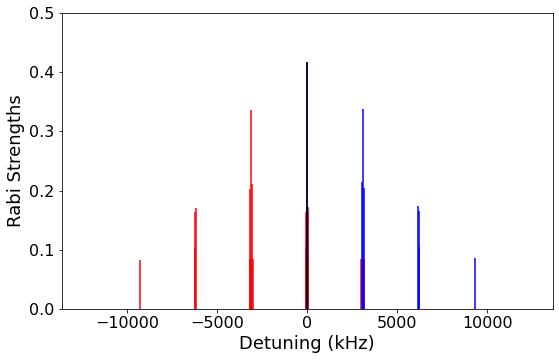

In [102]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)

sb, detune, stren = sideband_strength(N = 4, current_mode = np.array([[43], [42], [42], [41]]), sb = 1, xmin = -1000, xmax = 1000, ion_n = 0)

Maximum Rabi frequencies for four ions in phonon range [0, 250]:
[27597.89702858493, 27597.897028584764, 27597.89702858495, 27597.89702858499]


C:\Users\Corde\Documents\MSci Project\Simulations\MSci-Project-\Schrodinger.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  position = np.array([[0, 0.62996, 0, -0.62996],


Text(0, 0.5, '$Sin^{2}(\\omega t)$')

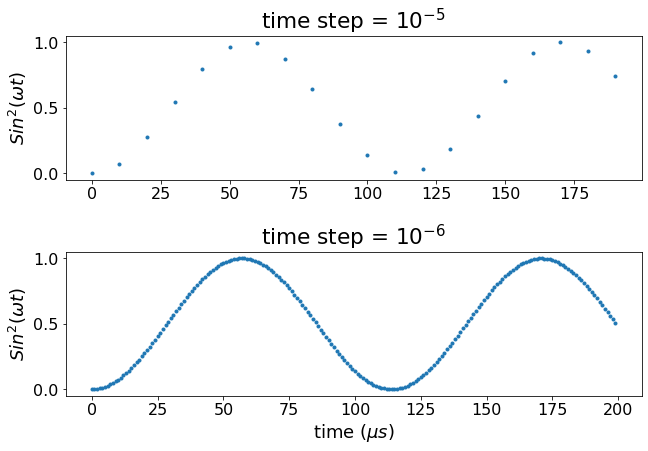

In [50]:
sideband = np.array([0, 0, 0, -1])
target_sideband = np.array([0, 0, 0, -1])

state = np.arange(0, 250)
modes_w, K, m =  icc_normal_modes_z(4)
frequencies = [round(i, -1) for i in modes_w * we]
detuning = sum(target_sideband * frequencies - sideband * frequencies)

R = LoadAnything('4_ions_planar.data')
current_mode = np.array([state for _ in range(4)])
exci = np.array([[0, 1, 2, 3] for _ in range(len(state))]).T
total_sb_stren = rb
for motion_state, mode, sb in zip(current_mode, range(4), sideband):
    sb_stren_this_mode = R[exci, mode, motion_state, motion_state + sb]
    total_sb_stren *= sb_stren_this_mode
detuning = sum(target_sideband * frequencies - sideband * frequencies)
print('Maximum Rabi frequencies for four ions in phonon range [0, 250]:')
print([max([frequency(total_sb_stren[ion][state], detuning) for state in range(len(total_sb_stren[ion]))]) for ion in range(len(total_sb_stren))])

fig = plt.figure(figsize=(8, 8/1.6))
ax2 = fig.add_axes([0, 0, 1, 0.4])
ax1 = fig.add_axes([0, 0.6, 1, 0.4])

t1 = np.arange(0, 20, 1)*1e-5
ax1.plot(t1*1e6, (np.sin(27597.89702858493*t1))**2, '.')
ax1.set_title(r'time step = $10^{-5}$')
ax1.set_ylabel('$Sin^{2}(\omega t)$')

t2 = np.arange(0, 200, 1)*1e-6
ax2.plot(t2*1e6, (np.sin(27597.89702858493*t2))**2, '.')
ax2.set_title(r'time step = $10^{-6}$')
ax2.set_xlabel('time ($\mu s$)')
ax2.set_ylabel('$Sin^{2}(\omega t)$')

([[-1, -1, 0, 1],
  [-1, 0, -1, 1],
  [-1, 0, 1, -1],
  [-1, 1, 0, -1],
  [1, -1, 0, -1],
  [1, 0, -1, -1]],
 [0.012918342641660398,
  0.012918342641660384,
  0.20508356095362423,
  0.2050835609536244,
  0.2056507197396703,
  0.20565071973967014],
 [[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]],
 [0.3217907754909659, 0.3622575793043274, 0.3622575793043275, 1.0])

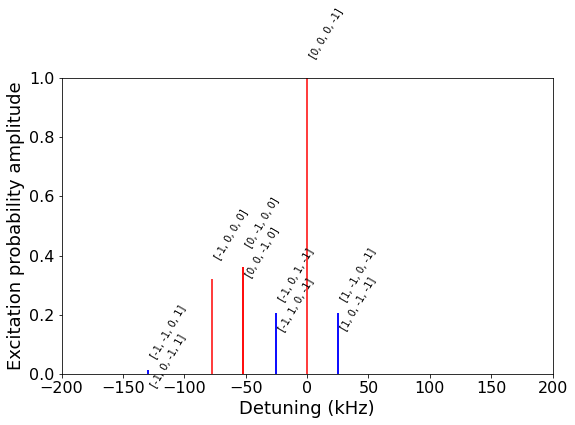

In [103]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
prob_amp(N = np.array([43, 42, 42, 41]), target_sideband = np.array([0, 0, 0, -1]))

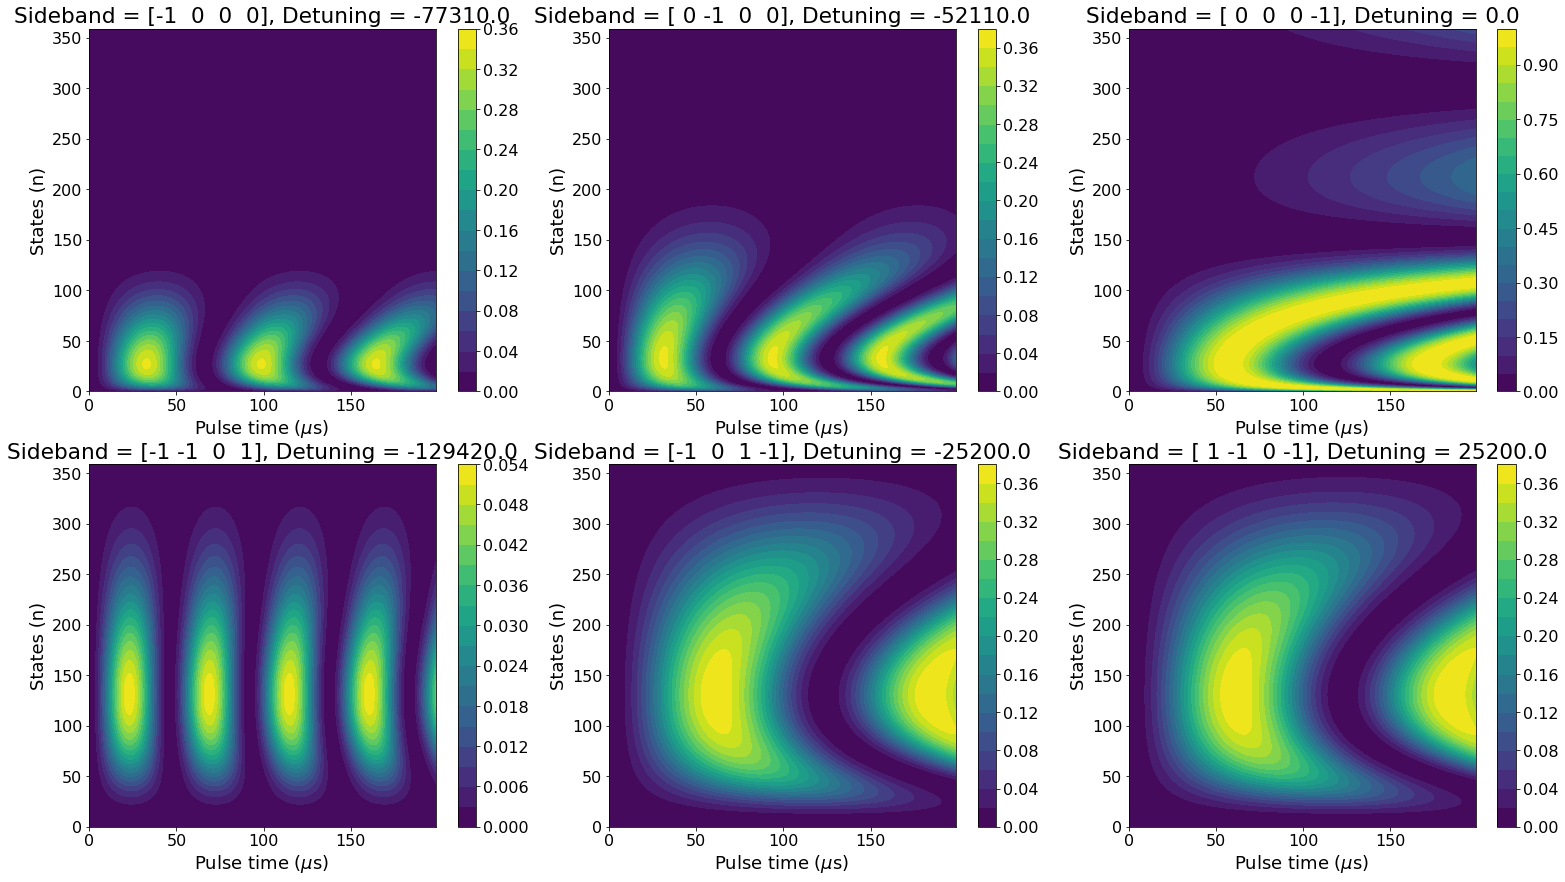

In [157]:
params = {'figure.figsize': [8.8*3, 2.7*8.8/1.618]} 
plt.rcParams.update(params)

plt.subplot(2, 3, 1)
twoD_Contour_4(sideband = np.array([-1, 0, 0, 0]), target_sideband = np.array([0, 0, 0, -1]), ion = 4)
plt.subplot(2, 3, 2)
twoD_Contour_4(sideband = np.array([0, -1, 0, 0]), target_sideband = np.array([0, 0, 0, -1]), ion = 4)
plt.subplot(2, 3, 3)
twoD_Contour_4(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4)
plt.subplot(2, 3, 4)
twoD_Contour_4(sideband = np.array([-1, -1, 0, 1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4)
plt.subplot(2, 3, 5)
twoD_Contour_4(sideband = np.array( [-1, 0, 1, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4)
plt.subplot(2, 3, 6)
twoD_Contour_4(sideband = np.array([1, -1, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4)

([[-1, -1, 0, 1],
  [-1, 0, -1, 1],
  [-1, 0, 1, -1],
  [-1, 1, 0, -1],
  [1, -1, 0, -1],
  [1, 0, -1, -1]],
 [0.03459160265988377,
  0.034591602659883744,
  0.18940732306916602,
  0.18940732306916616,
  0.03455162733185871,
  0.03455162733185868],
 [[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]],
 [0.8170375890558816, 0.5, 0.5, 0.48838058013784375])

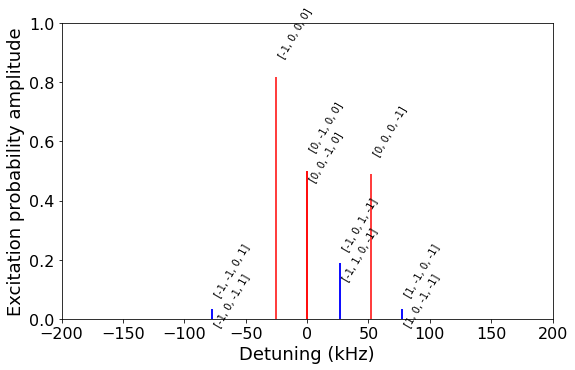

In [104]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
prob_amp(N = np.array([43, 42, 42, 41]), target_sideband = np.array([0, 0, -1, 0]))

([[-1, -1, 0, 1],
  [-1, 0, -1, 1],
  [-1, 0, 1, -1],
  [-1, 1, 0, -1],
  [1, -1, 0, -1],
  [1, 0, -1, -1]],
 [0.07029661930281234,
  0.07029661930281227,
  0.06993920022791551,
  0.06993920022791558,
  0.020255630069820556,
  0.020255630069820535],
 [[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]],
 [1.0, 0.459169715847103, 0.4591697158471031, 0.3025004849867676])

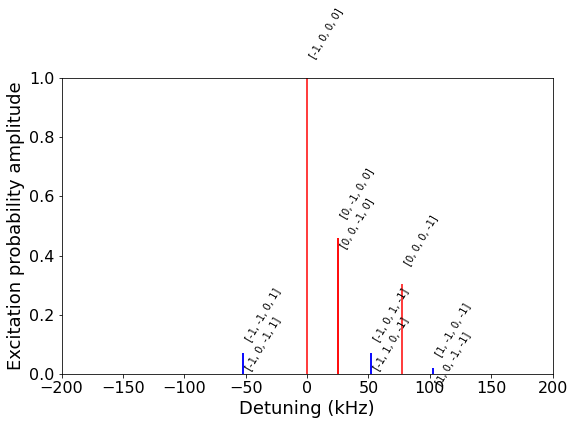

In [105]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)
prob_amp(N = np.array([43, 42, 42, 41]), target_sideband = np.array([-1, 0, 0, 0]))

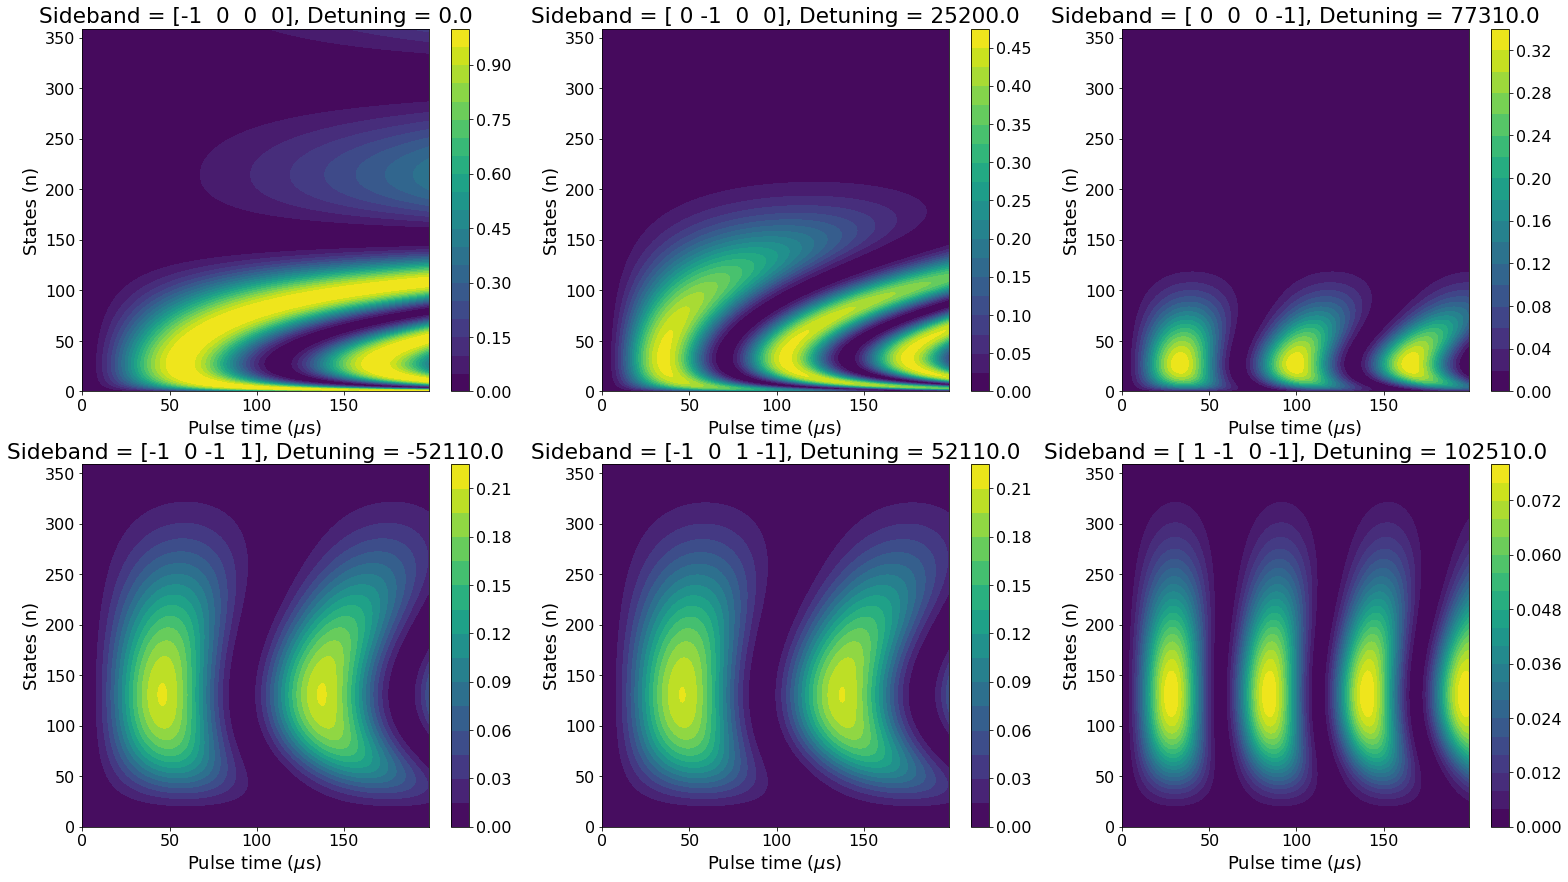

In [156]:
params = {'figure.figsize': [8.8*3, 2.7*8.8/1.618]} 
plt.rcParams.update(params)

plt.subplot(2, 3, 1)
twoD_Contour_4(sideband = np.array([-1, 0, 0, 0]), target_sideband = np.array([-1, 0, 0, 0]), ion = 4)
plt.subplot(2, 3, 2)
twoD_Contour_4(sideband = np.array([0, -1, 0, 0]), target_sideband = np.array([-1, 0, 0, 0]), ion = 4)
plt.subplot(2, 3, 3)
twoD_Contour_4(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([-1, 0, 0, 0]), ion = 4)
plt.subplot(2, 3, 4)
twoD_Contour_4(sideband = np.array([-1, 0, -1, 1]), target_sideband = np.array([-1, 0, 0, 0]), ion = 4)
plt.subplot(2, 3, 5)
twoD_Contour_4(sideband = np.array( [-1, 0, 1, -1]), target_sideband = np.array([-1, 0, 0, 0]), ion = 4)
plt.subplot(2, 3, 6)
twoD_Contour_4(sideband = np.array([1, -1, 0, -1]), target_sideband = np.array([-1, 0, 0, 0]), ion = 4)

<div style="background-color: #FFF8C6">
The above contour plots for excitation probability can be a good reference to decide which pulse length to use, but it is not always accurate since we assumed phonon states for all modes are the same when producing those plots. In actual cooling process, phonon states of all modes are rarely the same, below gives some example plots when phonon states of all modes are not the same. 

The below plots show resonant excitation of the COM mode, the states on the y-axis is the phonon states of the COM mode, phonon states of the tilt modes are 1, 20, 50, from left to right respectively:


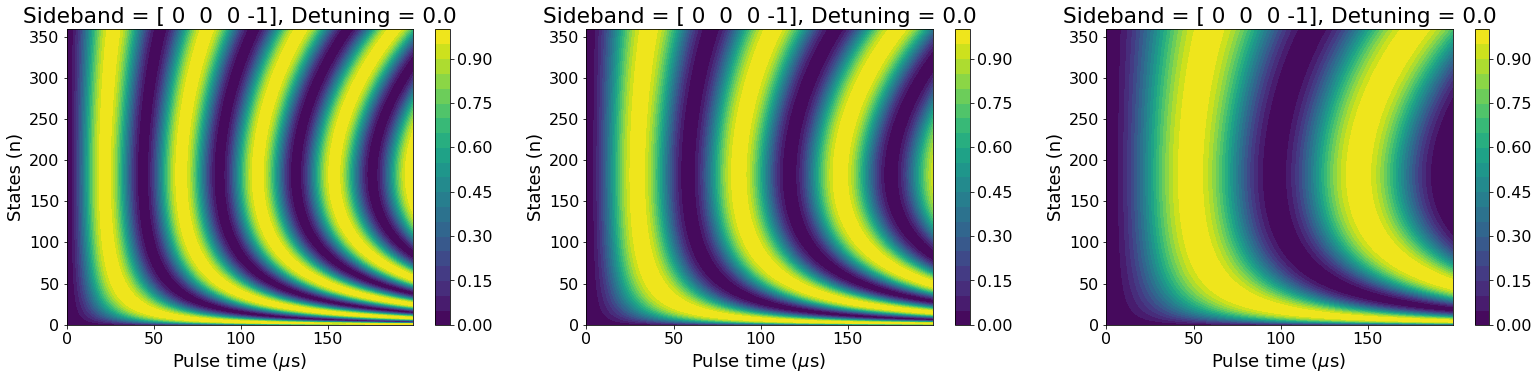

In [9]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('The below plots show resonant excitation of the COM mode, the states on the y-axis is the phonon states of the COM mode, phonon states of the tilt modes are 1, 20, 50, from left to right respectively:')
plt.subplot(1, 3, 1)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [1, 1, 1, 0])
plt.subplot(1, 3, 2)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [20, 20, 20, 0])
plt.subplot(1, 3, 3)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [50, 50, 50, 0])

<div style="background-color: #FFF8C6">
From the above, we can see that the excitation probability replies hugely on phonon states of each modes. For the COM mode, the larger the phonon states of the tilt modes, the lower the rabi frequency. The plot on the right shows that when tilt modes are at $n = 50$, maximum excitation probability occurs at a pulse length of around $60 \mu s$, on the contrary, when tilt modes also reach ground state, the maximum excitation probabiliry occurs at a pulse length of around $40 \mu s$.

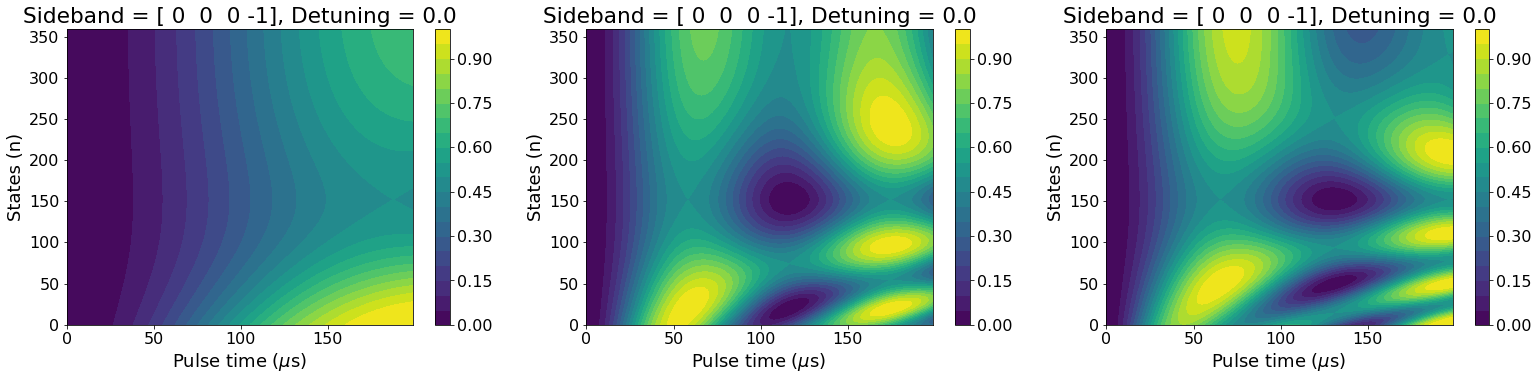

In [13]:
plt.subplot(1, 3, 1)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [1, 1, 0, 1])
plt.subplot(1, 3, 2)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [20, 20, 0, 20])
plt.subplot(1, 3, 3)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [50, 50, 0, 50])

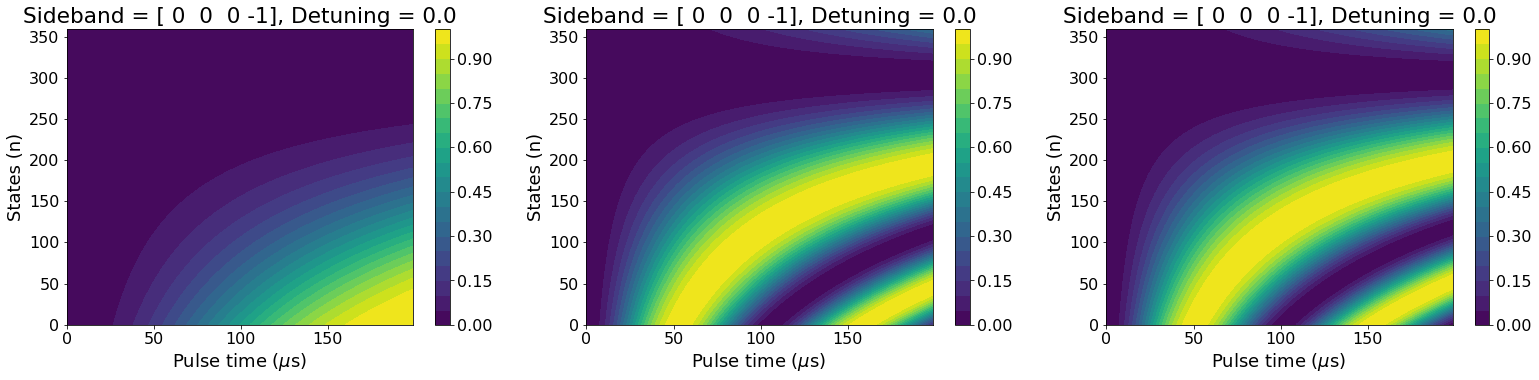

In [17]:
plt.subplot(1, 3, 1)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [0, 1, 1, 1])
plt.subplot(1, 3, 2)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [0, 20, 20, 20])
plt.subplot(1, 3, 3)
twoD_Contour_4_diff_n(sideband = np.array([0, 0, 0, -1]), target_sideband = np.array([0, 0, 0, -1]), ion = 4, 
                      mode_vector = [0, 50, 50, 50])

In [99]:
prob = 0.01
collections.Counter([np.random.choice(arange(2), size = None, p = [1-prob, prob]) for _ in range(10000)])

Counter({0: 9908, 1: 92})

C:\Users\Corde\Documents\MSci Project\Simulations\MSci-Project-\Schrodinger.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  position = np.array([[0, 0.62996, 0, -0.62996],


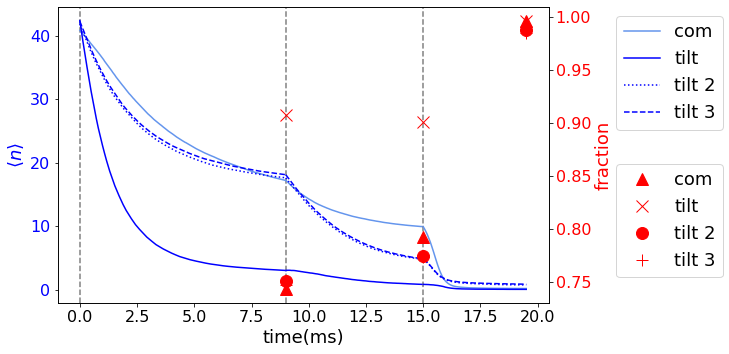

In [228]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)

laser33 = Pulse(pulse_length = 45e-6, N = 200, wavelength = 5.37750238 * we)
laser55 = Pulse(pulse_length = 45e-6, N = 100, wavelength = 5.51317846 * we)
laser66 = Pulse(pulse_length = 60e-6, N = 100, wavelength = 5.51317846 * we)
t4 = iontrap(G = 4, T0 = 0.001, n0 = np.array([50, 50, 50, 50]), M = 10000, ore = True, thermal_state = True, neglect_entanglement = True, basis = False)

lasers = np.array([laser33, laser66, laser55])
c4, b4, d4, e4, c_all4, b_all4, d_all4, e_all4, c_pc4, b_pc4, d_pc4, e_pc4 = plot_cooling_4_planar(t4, lasers)

Cooling trajectories for COM mode


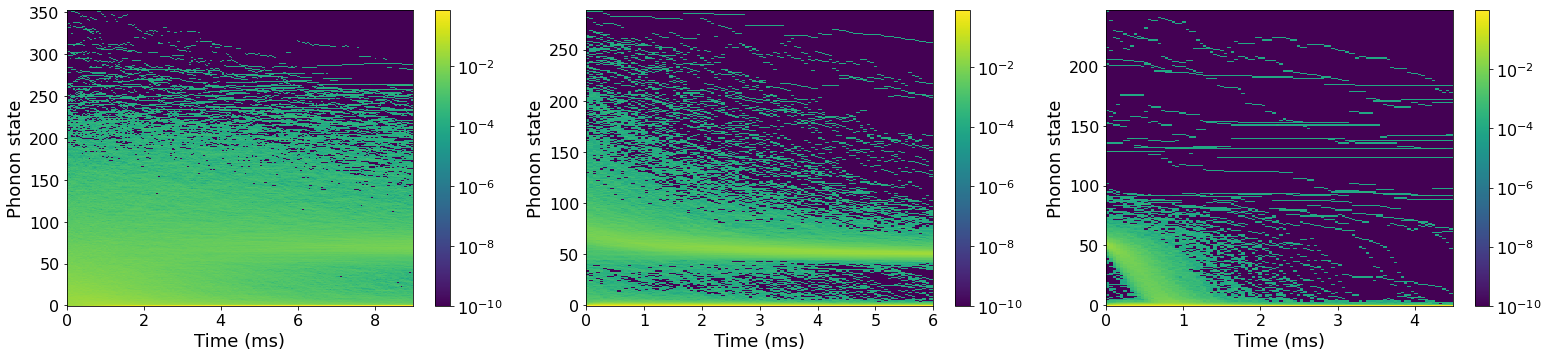

In [232]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for COM mode')
plt.subplot(1, 3, 1)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = c_all4[0])
plt.subplot(1, 3, 2)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = c_all4[1])
plt.subplot(1, 3, 3)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = c_all4[2])

Cooling trajectories for tilt 1 mode


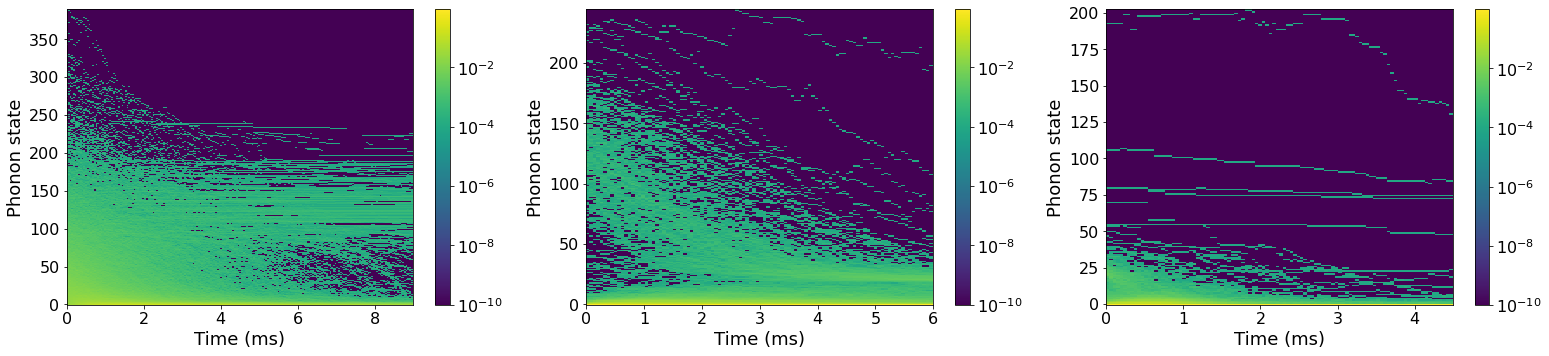

In [233]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for tilt 1 mode')
plt.subplot(1, 3, 1)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = b_all4[0])
plt.subplot(1, 3, 2)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = b_all4[1])
plt.subplot(1, 3, 3)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = b_all4[2])

Cooling trajectories for tilt 2 mode


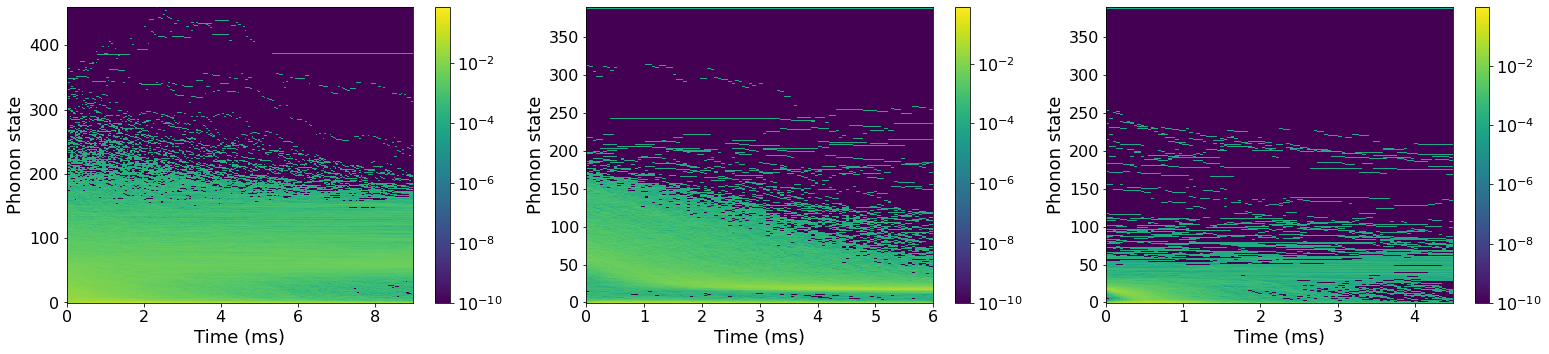

In [234]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for tilt 2 mode')
plt.subplot(1, 3, 1)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = d_all4[0])
plt.subplot(1, 3, 2)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = d_all4[1])
plt.subplot(1, 3, 3)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = d_all4[2])

Cooling trajectories for tilt 3 mode


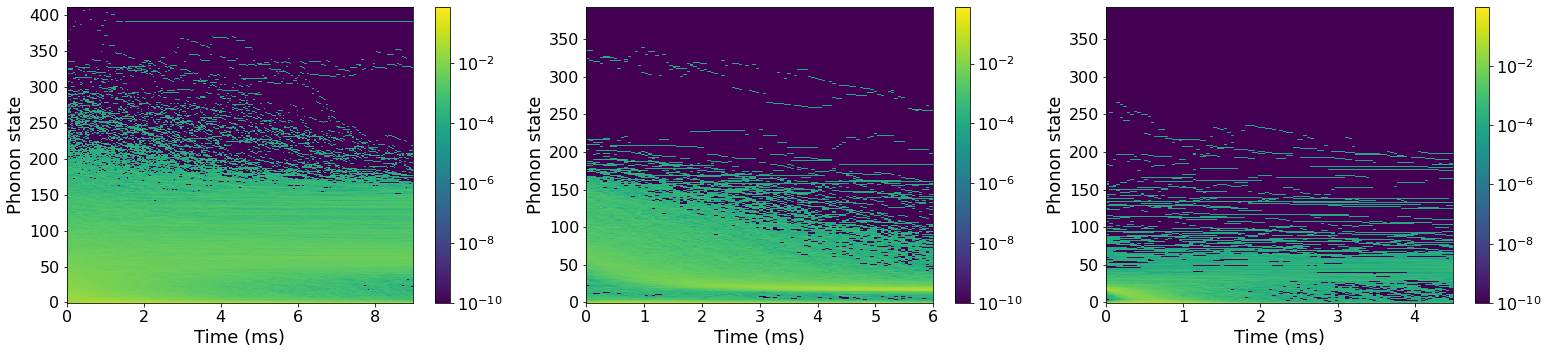

In [235]:
params = {'figure.figsize': [8.8*3, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for tilt 3 mode')
plt.subplot(1, 3, 1)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = e_all4[0])
plt.subplot(1, 3, 2)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = e_all4[1])
plt.subplot(1, 3, 3)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = e_all4[2])

C:\Users\Corde\Documents\MSci Project\Simulations\MSci-Project-\Schrodinger.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  position = np.array([[0, 0.62996, 0, -0.62996],


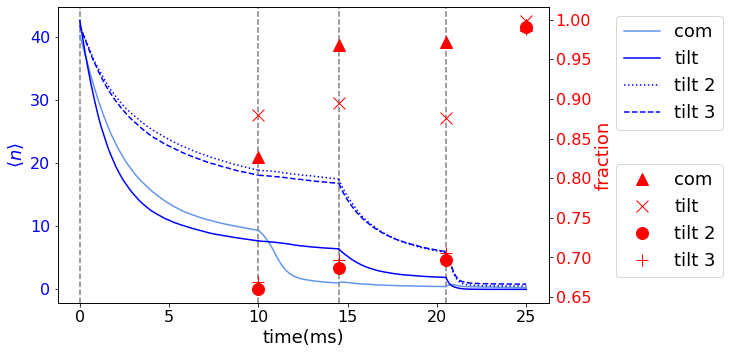

In [128]:
params = {'figure.figsize': [8.8, 8.8/1.618]} 
plt.rcParams.update(params)

laser33 = Pulse(pulse_length = 45e-6, N = 100, wavelength = 5.37750238 * we)
laser44 = Pulse(pulse_length = 50e-6, N = 200, wavelength = 5.42172742 * we)
laser55 = Pulse(pulse_length = 45e-6, N = 100, wavelength = 5.51317846 * we)
laser66 = Pulse(pulse_length = 60e-6, N = 100, wavelength = 5.51317846 * we)
t4 = iontrap(G = 4, T0 = 0.001, n0 = np.array([50, 50, 50, 50]), M = 5000, ore = True, thermal_state = True, neglect_entanglement = True, basis = False)

lasers = np.array([laser44, laser55, laser66, laser33])
c4, b4, d4, e4, c_all4, b_all4, d_all4, e_all4, c_pc4, b_pc4, d_pc4, e_pc4 = plot_cooling_4_planar(t4, lasers)

Cooling trajectories for COM mode


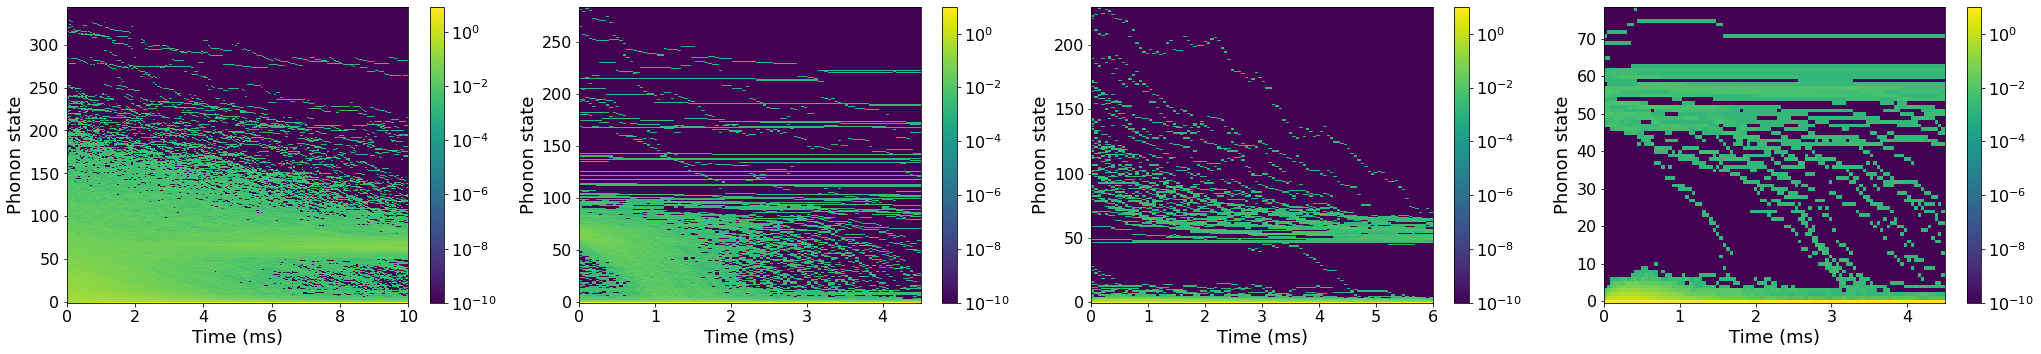

In [130]:
params = {'figure.figsize': [8.8*4, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for COM mode')
plt.subplot(1, 4, 1)
twod_traj_N_ions(pulse = laser44, trap = t4, all_data = c_all4[0])
plt.subplot(1, 4, 2)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = c_all4[1])
plt.subplot(1, 4, 3)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = c_all4[2])
plt.subplot(1, 4, 4)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = c_all4[3])

Cooling trajectories for tilt 1 mode


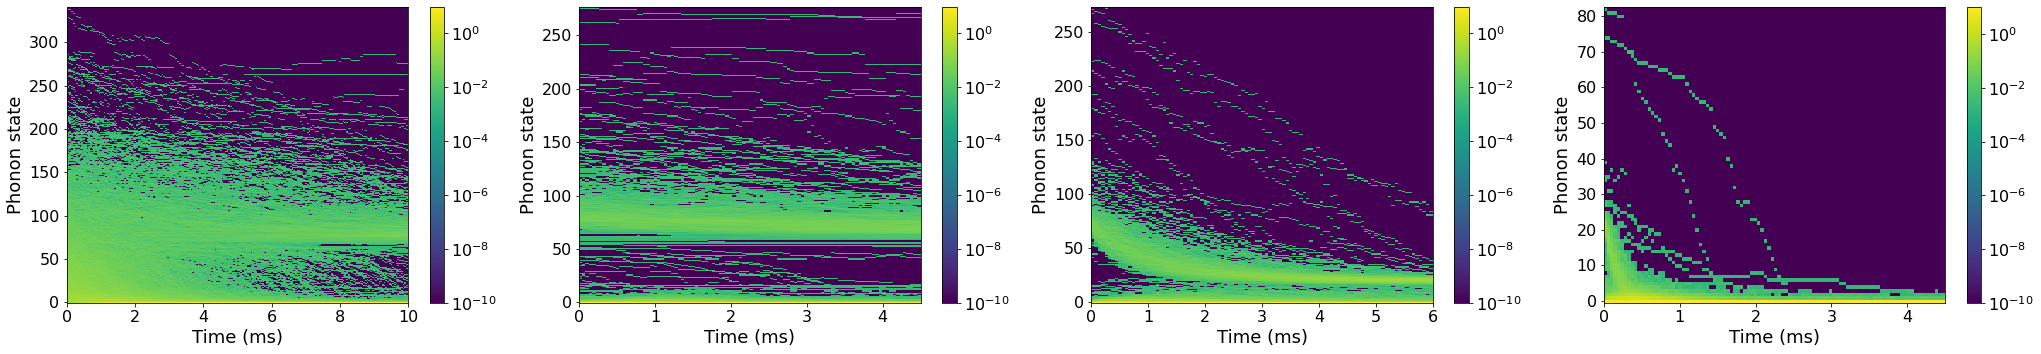

In [131]:
params = {'figure.figsize': [8.8*4, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for tilt 1 mode')
plt.subplot(1, 4, 1)
twod_traj_N_ions(pulse = laser44, trap = t4, all_data = b_all4[0])
plt.subplot(1, 4, 2)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = b_all4[1])
plt.subplot(1, 4, 3)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = b_all4[2])
plt.subplot(1, 4, 4)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = b_all4[3])

Cooling trajectories for tilt 2 mode


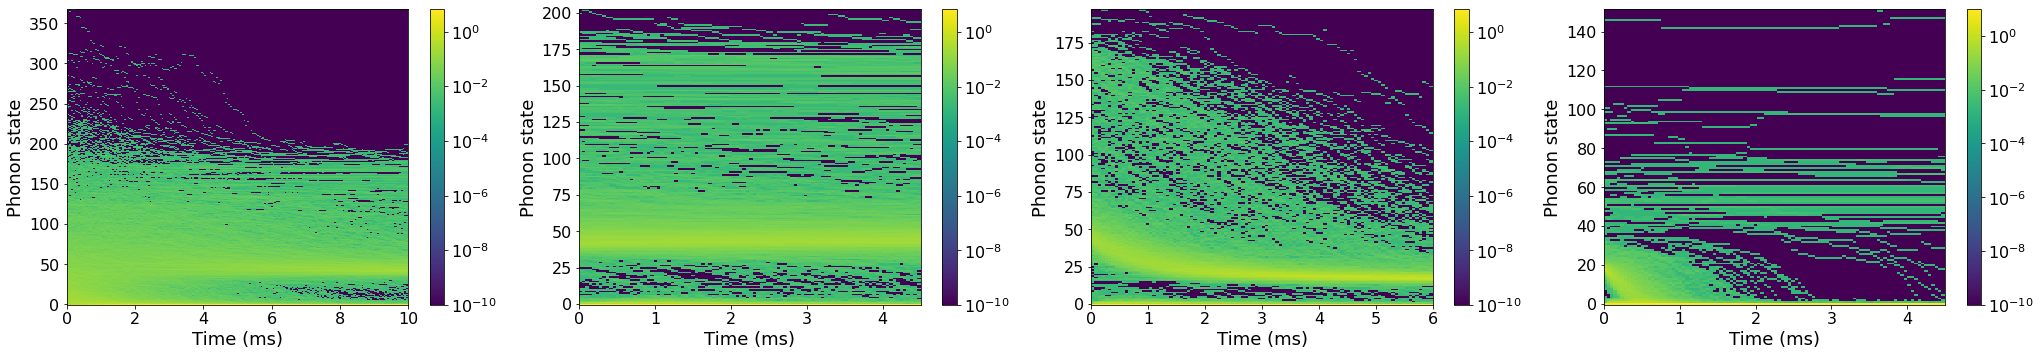

In [132]:
params = {'figure.figsize': [8.8*4, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for tilt 2 mode')
plt.subplot(1, 4, 1)
twod_traj_N_ions(pulse = laser44, trap = t4, all_data = d_all4[0])
plt.subplot(1, 4, 2)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = d_all4[1])
plt.subplot(1, 4, 3)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = d_all4[2])
plt.subplot(1, 4, 4)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = d_all4[3])

Cooling trajectories for tilt 3 mode


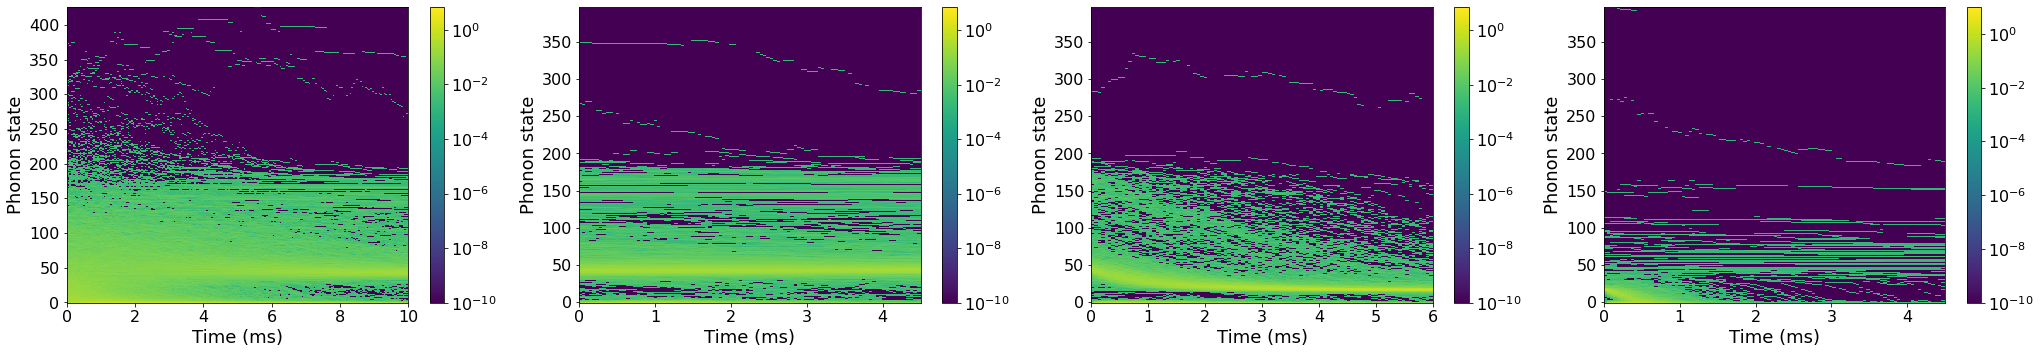

In [133]:
params = {'figure.figsize': [8.8*4, 8.8/1.618]} 
plt.rcParams.update(params)
print('Cooling trajectories for tilt 3 mode')
plt.subplot(1, 4, 1)
twod_traj_N_ions(pulse = laser44, trap = t4, all_data = e_all4[0])
plt.subplot(1, 4, 2)
twod_traj_N_ions(pulse = laser55, trap = t4, all_data = e_all4[1])
plt.subplot(1, 4, 3)
twod_traj_N_ions(pulse = laser66, trap = t4, all_data = e_all4[2])
plt.subplot(1, 4, 4)
twod_traj_N_ions(pulse = laser33, trap = t4, all_data = e_all4[3])

## (Maybe) Useful Code <a id="code"></a>

In [29]:
R = np.zeros([rab_dim for i in range(2*2)]) # initialisation
import itertools
print(list((a,b) for a,b in itertools.product(range(4), repeat=2)))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [24]:
a = np.array([1, 2])
b = np.array([2, 3])
print(np.multiply(a, b).astype('int'))

[2 6]


In [11]:
n0 = np.array([50, 30])
T0_th = nave_to_T(n0, wz)  # theoretical value of initial temperature
#distribution_n0 = Boltzmann_state(T0_th, wz, size = 100)  # initialise array of n0
#actual_aven0, maxn0 = np.average(distribution_n0), np.max(distribution_n0) # average n and maximum n

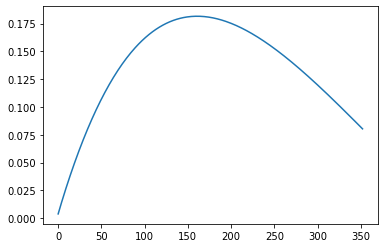

In [18]:
data = []
for i in range(353):
    s = all_rabi_strength[1]["resonant_excite"][2][i][i+2] * all_rabi_strength[0]["off_excite"][2][30][30]
    data.append(s)
plt.plot(data)

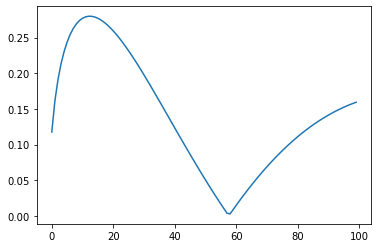

In [11]:
data = []
for i in range(100):
    s = all_rabi_strength[1]["resonant_excite"][1][i][i+1] * all_rabi_strength[0]["off_excite"][1][i][i]
    data.append(s)
plt.plot(data)

In [8]:
all_rabi_strength[1]["decay"][30][28:33]

array([0.42957756, 0.51773149, 0.01381271, 0.50876636, 0.4419175 ])

In [17]:
a = np.array([1, 2])
b = np.array([1, 1])
a[-0] == a[0]

True

In [23]:
e = np.zeros((3, 4))
        # all_trial_n[0, :] = self.n
#e[0, :]
e

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [18]:
import numpy as np
# matrix = np.array([[1, 1, 1], [0, np.sqrt(2), np.sqrt(2)], [-1, 1, 1]])
# matrix = np.array([[1, 1], [1, -1]])
# matrix = np.array([[1, 0.5], [1, -0.5]])
np.matmul(matrix, matrix.T)

array([[2, 0],
       [0, 2]])

In [8]:
a = np.array([1, 2, 3, 4])
b = np.array([6, 7, 8, 9])
c = [a, b]

a[:,None]


array([[1],
       [2],
       [3],
       [4]])

In [6]:
all_rabi_strength = pickle.load(open('test2', 'rb'))
all_rabi_strength[0]

array([[9.75410633e-01, 2.17657519e-01, 3.43435247e-02, 4.42456344e-03,
        4.93658501e-04],
       [2.17657519e-01, 9.26841555e-01, 3.00150647e-01, 5.84974127e-02,
        8.73896971e-03],
       [3.43435247e-02, 3.00150647e-01, 8.79481688e-01, 3.58377834e-01,
        8.13489387e-02],
       [4.42456344e-03, 5.84974127e-02, 3.58377834e-01, 8.33310962e-01,
        4.03338688e-01],
       [4.93658501e-04, 8.73896971e-03, 8.13489387e-02, 4.03338688e-01,
        7.88309557e-01]])

something something $\langle something \rangle)$

In [144]:
state = np.arange(50, 51, 1)
both_states = np.array([state, state])
R = LoadAnything('ions' + str(2) + '_laser_rabi.data')
no_excited, h_non_zero, which_ion_change = laser_sb_ham_info(2)
print(which_ion_change)
which_ion_chg_arr = ones((both_states.shape[1], *which_ion_change.shape),
                 dtype = 'int') * (which_ion_change - 1)
print(which_ion_chg_arr)
print(which_ion_chg_arr.transpose(1,2,0))
# calculate total sideband strengths (terms in the hamiltonian matrix)
total_sb_stren = 1
for motion_state, sideband, mode in zip(both_states, [0, -2], range(2)):
    changed_motion_stt = no_excited[:,None] * sideband + motion_state
    sb_stren_this_mode = R[which_ion_chg_arr.transpose(1,2,0),mode,changed_motion_stt[:,None],
                        changed_motion_stt[:,None].transpose(1,0,2)]
    total_sb_stren = total_sb_stren * sb_stren_this_mode
print(total_sb_stren)
H = einsum('ijk,ij->kij', total_sb_stren, h_non_zero)
print(H)

[[0 1 2 0]
 [1 0 0 2]
 [2 0 0 1]
 [0 2 1 0]]
[[[-1  0  1 -1]
  [ 0 -1 -1  1]
  [ 1 -1 -1  0]
  [-1  1  0 -1]]]
[[[-1]
  [ 0]
  [ 1]
  [-1]]

 [[ 0]
  [-1]
  [-1]
  [ 1]]

 [[ 1]
  [-1]
  [-1]
  [ 0]]

 [[-1]
  [ 1]
  [ 0]
  [-1]]]
[[[0.0343629 ]
  [0.02418844]
  [0.02418844]
  [0.00152639]]

 [[0.02418844]
  [0.03607063]
  [0.03607063]
  [0.02344892]]

 [[0.02418844]
  [0.03607063]
  [0.03607063]
  [0.02344892]]

 [[0.00152639]
  [0.02344892]
  [0.02344892]
  [0.0378066 ]]]
[[[0.         0.02418844 0.02418844 0.        ]
  [0.02418844 0.         0.         0.02344892]
  [0.02418844 0.         0.         0.02344892]
  [0.         0.02344892 0.02344892 0.        ]]]


In [164]:
h_st = laser_sb_ham_info(2)
print(H.shape)
psi_0 = eye(1, M = H.shape[-1])[0]
print(psi_0)
# solve the schrodinger's equation
psi_t = SchrodingerEqn(H, psi_0, array([1e-5]), h_factor = rb / 2)[:,:,0]
print(psi_t)
# calculate excite probabilty
probs  = (psi_t * psi_t.conj()).real
print(probs)

# determine the state which the system is excited to via Monte Carlo
state_hilbertspace = array([np.random.choice(H.shape[-1], size = None, p = prob / np.sum(prob)) for prob in probs])
print(state_hilbertspace)
ham = H
psit = psi_t
stt_hilb = state_hilbertspace
# determine which ion(s) get excited
excite = which_ion_excite(2)[state_hilbertspace,:].T
# shift the motional states
outer([0, -1], h_st[0][state_hilbertspace])

(1, 4, 4)
[1. 0. 0. 0.]
[[ 9.99076354e-01+0.00000000e+00j -5.55111512e-17-3.03779291e-02j
   0.00000000e+00-3.03779291e-02j -8.95407242e-04+5.20417043e-18j]]
[[9.98153561e-01 9.22818574e-04 9.22818574e-04 8.01754129e-07]]
[0]


array([[0],
       [0]])

In [154]:
which_ion_excite(2)[state_hilbertspace,:].T

array([[0],
       [0]])

In [166]:
h_st[0][3]

2

In [175]:
data = pickle.load(open('ions2_laser_rabi.data', 'rb'))

In [182]:
len(data)

2

In [180]:
data[0][0][0]

762